# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

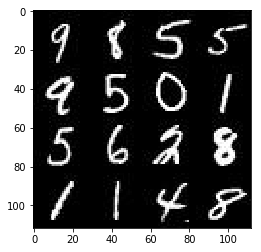

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

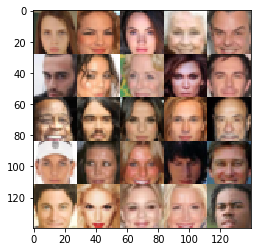

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_placeholder = tf.placeholder(tf.float32, shape=(None,image_width,image_height,image_channels))
    z_placeholder = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_placeholder = tf.placeholder(tf.float32,shape=())

    return real_placeholder, z_placeholder, learning_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        # First layer. (None, 28, 28, 3)
        x1 = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, 
                              padding="same", strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha*x1, x1)
        # x1 = tf.nn.dropout(x=x1, keep_prob=0.8)
        
        # Second layer. (None, 14,14,32)
        x2 = tf.layers.conv2d(inputs=x1, filters=64, kernel_size=5, 
                              padding="same", strides=2,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x=x2, keep_prob=0.8)
        
        # Third layer. (None,7,7,64)
        x3 = tf.layers.conv2d(inputs=x2, filters=128, kernel_size=5, padding="same", 
                              strides=2,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x=x3, keep_prob=0.8)
        
        # Output layer. ()
        flat = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(flat,units=1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=(not is_train)):
        
        # First Layer 
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second Layer (7,7,512)
        x2 = tf.layers.conv2d_transpose(x1,filters=256,kernel_size=5, strides=2,
                                        padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x=x2, keep_prob=0.8)
        
        # Third layer (14,14,256)
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, 
                                        padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x=x3, keep_prob=0.8)
        
        # Output (28,28,128)
        #x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=1, 
        #                                padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, 
                                            padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        logits = tf.tanh(x4)
        
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real))
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if "discriminator" in var.name]
    g_vars = [var for var in t_vars if "generator" in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, losses = [], []
    steps = 0
    if data_image_mode=="RGB":
        num_channel=3
    elif data_image_mode=="L":
        num_channel=1
    
    input_real, input_z, learning_p = model_inputs(image_channels=num_channel,image_width=28,
                                                      image_height=28,z_dim=z_dim)
    
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z,out_channel_dim=num_channel)
    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, beta1=beta1,learning_rate=learning_rate)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random Noise for generator
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                batch_images = 2 * batch_images
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count), 
                         "Discriminator loss: {:.4f}...".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g)
                         )
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    s = show_generator_output(sess=sess,n_images=16,input_z=input_z, 
                                          image_mode=data_image_mode,out_channel_dim=num_channel)
                    samples.append(s)
                    
        saver.save(sess, "./checkpoint/generator.ckpt")
        
    return losses
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator loss: 0.5512... Generator loss: 5.1967
Epoch 0/2... Discriminator loss: 0.4022... Generator loss: 7.0291
Epoch 0/2... Discriminator loss: 0.7281... Generator loss: 13.5041
Epoch 0/2... Discriminator loss: 0.3901... Generator loss: 9.9763
Epoch 0/2... Discriminator loss: 0.3739... Generator loss: 7.8881
Epoch 0/2... Discriminator loss: 0.3489... Generator loss: 7.8408
Epoch 0/2... Discriminator loss: 0.3560... Generator loss: 7.3120
Epoch 0/2... Discriminator loss: 0.3531... Generator loss: 7.2004
Epoch 0/2... Discriminator loss: 0.3425... Generator loss: 7.8132
Epoch 0/2... Discriminator loss: 0.3406... Generator loss: 7.8111


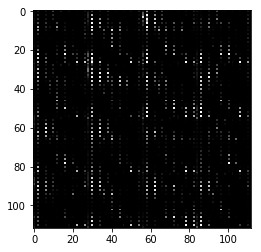

Epoch 0/2... Discriminator loss: 0.3364... Generator loss: 8.3245
Epoch 0/2... Discriminator loss: 0.3452... Generator loss: 8.3655
Epoch 0/2... Discriminator loss: 0.3346... Generator loss: 8.2704
Epoch 0/2... Discriminator loss: 0.3359... Generator loss: 8.1616
Epoch 0/2... Discriminator loss: 0.3368... Generator loss: 7.9964
Epoch 0/2... Discriminator loss: 0.3389... Generator loss: 9.4902
Epoch 0/2... Discriminator loss: 0.3366... Generator loss: 8.8473
Epoch 0/2... Discriminator loss: 0.3387... Generator loss: 8.7679
Epoch 0/2... Discriminator loss: 0.3414... Generator loss: 8.8061
Epoch 0/2... Discriminator loss: 5.4797... Generator loss: 0.0317


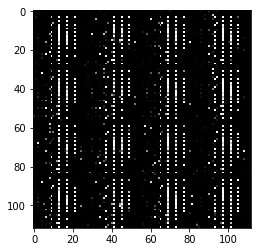

Epoch 0/2... Discriminator loss: 1.0538... Generator loss: 1.9715
Epoch 0/2... Discriminator loss: 0.4120... Generator loss: 7.9318
Epoch 0/2... Discriminator loss: 3.9256... Generator loss: 7.0210
Epoch 0/2... Discriminator loss: 0.5666... Generator loss: 2.1393
Epoch 0/2... Discriminator loss: 1.2475... Generator loss: 0.9140
Epoch 0/2... Discriminator loss: 2.0186... Generator loss: 3.3682
Epoch 0/2... Discriminator loss: 1.1414... Generator loss: 1.2788
Epoch 0/2... Discriminator loss: 1.3224... Generator loss: 0.8995
Epoch 0/2... Discriminator loss: 0.9810... Generator loss: 2.2415
Epoch 0/2... Discriminator loss: 1.1521... Generator loss: 1.0040


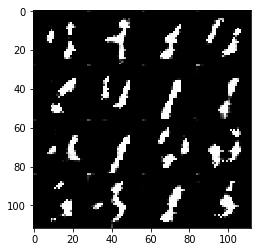

Epoch 0/2... Discriminator loss: 1.3419... Generator loss: 0.9495
Epoch 0/2... Discriminator loss: 0.9604... Generator loss: 1.5727
Epoch 0/2... Discriminator loss: 1.1870... Generator loss: 1.8054
Epoch 0/2... Discriminator loss: 1.2569... Generator loss: 1.0435
Epoch 0/2... Discriminator loss: 1.0985... Generator loss: 1.1711
Epoch 0/2... Discriminator loss: 1.0731... Generator loss: 1.1056
Epoch 0/2... Discriminator loss: 1.0891... Generator loss: 1.1996
Epoch 0/2... Discriminator loss: 1.2781... Generator loss: 0.9122
Epoch 0/2... Discriminator loss: 1.0572... Generator loss: 1.3825
Epoch 0/2... Discriminator loss: 1.7164... Generator loss: 0.3698


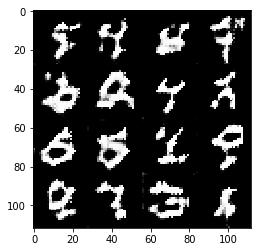

Epoch 0/2... Discriminator loss: 1.3837... Generator loss: 0.5744
Epoch 0/2... Discriminator loss: 1.3485... Generator loss: 0.8212
Epoch 0/2... Discriminator loss: 1.2827... Generator loss: 0.9939
Epoch 0/2... Discriminator loss: 1.1736... Generator loss: 1.3973
Epoch 0/2... Discriminator loss: 1.1713... Generator loss: 0.9595
Epoch 0/2... Discriminator loss: 1.2633... Generator loss: 2.0309
Epoch 0/2... Discriminator loss: 1.2405... Generator loss: 1.4819
Epoch 0/2... Discriminator loss: 1.2611... Generator loss: 0.8986
Epoch 0/2... Discriminator loss: 1.3953... Generator loss: 0.9103
Epoch 0/2... Discriminator loss: 1.5666... Generator loss: 0.6642


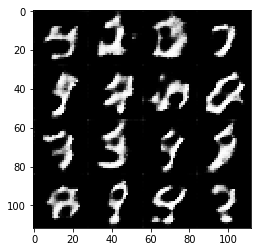

Epoch 0/2... Discriminator loss: 1.3221... Generator loss: 0.9942
Epoch 0/2... Discriminator loss: 1.1988... Generator loss: 0.8877
Epoch 0/2... Discriminator loss: 1.2947... Generator loss: 0.7779
Epoch 0/2... Discriminator loss: 1.5450... Generator loss: 1.5186
Epoch 0/2... Discriminator loss: 1.1683... Generator loss: 1.1280
Epoch 0/2... Discriminator loss: 1.2247... Generator loss: 0.8821
Epoch 0/2... Discriminator loss: 1.3077... Generator loss: 1.0525
Epoch 0/2... Discriminator loss: 1.1512... Generator loss: 1.1900
Epoch 0/2... Discriminator loss: 1.4608... Generator loss: 0.6309
Epoch 0/2... Discriminator loss: 1.4818... Generator loss: 0.6127


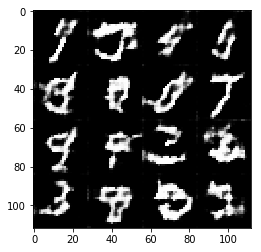

Epoch 0/2... Discriminator loss: 1.2583... Generator loss: 0.7596
Epoch 0/2... Discriminator loss: 1.4723... Generator loss: 0.6335
Epoch 0/2... Discriminator loss: 1.4746... Generator loss: 0.6149
Epoch 0/2... Discriminator loss: 1.4034... Generator loss: 0.6623
Epoch 0/2... Discriminator loss: 1.2664... Generator loss: 1.3345
Epoch 0/2... Discriminator loss: 1.2747... Generator loss: 1.1471
Epoch 0/2... Discriminator loss: 1.3027... Generator loss: 0.8168
Epoch 0/2... Discriminator loss: 1.4344... Generator loss: 0.6949
Epoch 0/2... Discriminator loss: 1.3849... Generator loss: 0.8338
Epoch 0/2... Discriminator loss: 1.5241... Generator loss: 0.5799


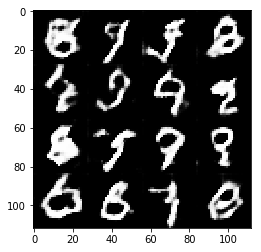

Epoch 0/2... Discriminator loss: 1.2696... Generator loss: 0.8521
Epoch 0/2... Discriminator loss: 1.3425... Generator loss: 0.8710
Epoch 0/2... Discriminator loss: 1.2848... Generator loss: 0.6686
Epoch 0/2... Discriminator loss: 1.3411... Generator loss: 0.9617
Epoch 0/2... Discriminator loss: 1.2816... Generator loss: 0.7997
Epoch 0/2... Discriminator loss: 1.2439... Generator loss: 1.1637
Epoch 0/2... Discriminator loss: 1.4580... Generator loss: 0.6414
Epoch 0/2... Discriminator loss: 1.2403... Generator loss: 1.0197
Epoch 0/2... Discriminator loss: 1.2050... Generator loss: 1.1196
Epoch 0/2... Discriminator loss: 1.2395... Generator loss: 1.0828


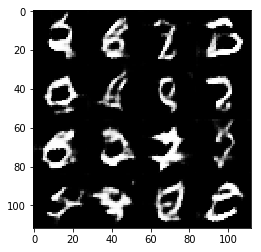

Epoch 0/2... Discriminator loss: 1.3722... Generator loss: 0.5953
Epoch 0/2... Discriminator loss: 1.2414... Generator loss: 0.8225
Epoch 0/2... Discriminator loss: 1.1773... Generator loss: 0.7717
Epoch 0/2... Discriminator loss: 1.4173... Generator loss: 0.6940
Epoch 0/2... Discriminator loss: 1.2115... Generator loss: 0.6789
Epoch 0/2... Discriminator loss: 1.2927... Generator loss: 1.1684
Epoch 0/2... Discriminator loss: 1.1703... Generator loss: 0.9807
Epoch 0/2... Discriminator loss: 1.0495... Generator loss: 1.2263
Epoch 0/2... Discriminator loss: 1.2327... Generator loss: 0.8037
Epoch 0/2... Discriminator loss: 1.2254... Generator loss: 1.0388


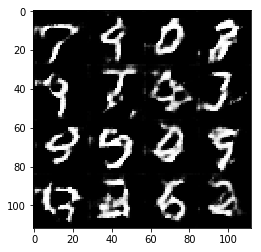

Epoch 0/2... Discriminator loss: 1.1061... Generator loss: 1.2482
Epoch 0/2... Discriminator loss: 1.3735... Generator loss: 0.8622
Epoch 0/2... Discriminator loss: 1.3362... Generator loss: 1.4306
Epoch 0/2... Discriminator loss: 1.2308... Generator loss: 1.1014
Epoch 0/2... Discriminator loss: 1.3325... Generator loss: 0.6166
Epoch 0/2... Discriminator loss: 1.1988... Generator loss: 0.9774
Epoch 0/2... Discriminator loss: 1.1822... Generator loss: 0.9650
Epoch 0/2... Discriminator loss: 1.1614... Generator loss: 1.1721
Epoch 0/2... Discriminator loss: 1.1961... Generator loss: 1.7080
Epoch 0/2... Discriminator loss: 1.2350... Generator loss: 1.5725


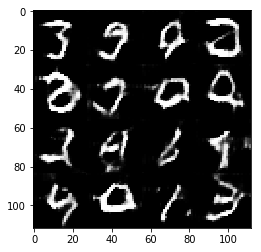

Epoch 0/2... Discriminator loss: 1.2684... Generator loss: 1.6250
Epoch 0/2... Discriminator loss: 1.2299... Generator loss: 0.9996
Epoch 0/2... Discriminator loss: 1.0793... Generator loss: 1.0251
Epoch 0/2... Discriminator loss: 1.2683... Generator loss: 1.1824
Epoch 0/2... Discriminator loss: 1.1980... Generator loss: 1.2916
Epoch 0/2... Discriminator loss: 1.1881... Generator loss: 0.9884
Epoch 0/2... Discriminator loss: 1.1904... Generator loss: 1.1073
Epoch 0/2... Discriminator loss: 1.2863... Generator loss: 0.9672
Epoch 0/2... Discriminator loss: 1.3390... Generator loss: 0.9745
Epoch 0/2... Discriminator loss: 1.1509... Generator loss: 1.3609


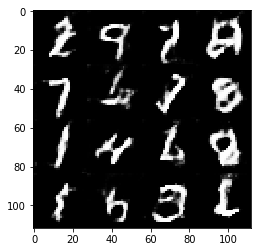

Epoch 0/2... Discriminator loss: 1.2921... Generator loss: 1.3125
Epoch 0/2... Discriminator loss: 1.1964... Generator loss: 0.9766
Epoch 0/2... Discriminator loss: 1.1932... Generator loss: 1.0709
Epoch 0/2... Discriminator loss: 1.1680... Generator loss: 0.8006
Epoch 0/2... Discriminator loss: 1.2826... Generator loss: 0.8872
Epoch 0/2... Discriminator loss: 1.3057... Generator loss: 1.1361
Epoch 0/2... Discriminator loss: 1.4605... Generator loss: 0.6802
Epoch 0/2... Discriminator loss: 1.0823... Generator loss: 1.1857
Epoch 0/2... Discriminator loss: 1.0028... Generator loss: 1.4039
Epoch 0/2... Discriminator loss: 1.2386... Generator loss: 1.0160


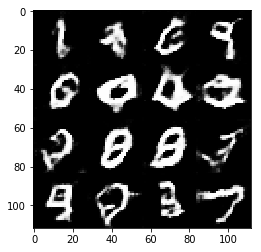

Epoch 0/2... Discriminator loss: 1.1670... Generator loss: 1.1936
Epoch 0/2... Discriminator loss: 1.2721... Generator loss: 0.9447
Epoch 0/2... Discriminator loss: 1.2542... Generator loss: 1.0750
Epoch 0/2... Discriminator loss: 1.2115... Generator loss: 0.8796
Epoch 0/2... Discriminator loss: 1.5760... Generator loss: 1.5684
Epoch 0/2... Discriminator loss: 1.2056... Generator loss: 0.8557
Epoch 0/2... Discriminator loss: 1.1356... Generator loss: 1.1040
Epoch 0/2... Discriminator loss: 1.1476... Generator loss: 1.2225
Epoch 0/2... Discriminator loss: 1.7127... Generator loss: 0.5373
Epoch 0/2... Discriminator loss: 1.3305... Generator loss: 1.1984


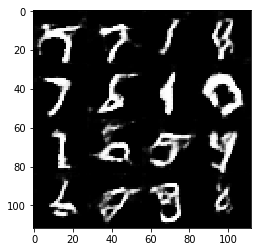

Epoch 0/2... Discriminator loss: 1.1005... Generator loss: 1.2914
Epoch 0/2... Discriminator loss: 1.0844... Generator loss: 1.1487
Epoch 0/2... Discriminator loss: 1.3309... Generator loss: 1.1638
Epoch 0/2... Discriminator loss: 1.3337... Generator loss: 0.9080
Epoch 0/2... Discriminator loss: 1.4212... Generator loss: 0.8136
Epoch 0/2... Discriminator loss: 1.2651... Generator loss: 1.6304
Epoch 0/2... Discriminator loss: 1.2818... Generator loss: 0.6959
Epoch 0/2... Discriminator loss: 1.2184... Generator loss: 1.5194
Epoch 0/2... Discriminator loss: 1.2203... Generator loss: 1.1094
Epoch 0/2... Discriminator loss: 1.2042... Generator loss: 1.3446


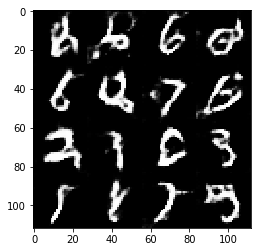

Epoch 0/2... Discriminator loss: 1.2505... Generator loss: 1.4644
Epoch 0/2... Discriminator loss: 1.2429... Generator loss: 1.0255
Epoch 0/2... Discriminator loss: 1.0863... Generator loss: 1.1374
Epoch 0/2... Discriminator loss: 1.3547... Generator loss: 0.7245
Epoch 0/2... Discriminator loss: 1.2996... Generator loss: 0.6499
Epoch 0/2... Discriminator loss: 1.3869... Generator loss: 0.8662
Epoch 0/2... Discriminator loss: 0.8809... Generator loss: 1.1598
Epoch 0/2... Discriminator loss: 1.1339... Generator loss: 1.0200
Epoch 0/2... Discriminator loss: 1.1742... Generator loss: 0.8427
Epoch 0/2... Discriminator loss: 1.0306... Generator loss: 1.1279


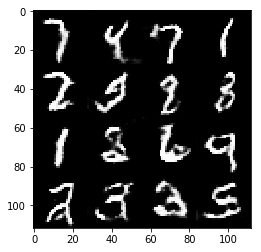

Epoch 0/2... Discriminator loss: 1.0840... Generator loss: 0.9719
Epoch 0/2... Discriminator loss: 1.2346... Generator loss: 0.8731
Epoch 0/2... Discriminator loss: 1.2056... Generator loss: 1.3869
Epoch 0/2... Discriminator loss: 1.4398... Generator loss: 0.7639
Epoch 0/2... Discriminator loss: 1.2303... Generator loss: 1.2455
Epoch 0/2... Discriminator loss: 1.1589... Generator loss: 1.2485
Epoch 0/2... Discriminator loss: 1.2431... Generator loss: 0.6642
Epoch 0/2... Discriminator loss: 1.3758... Generator loss: 1.5337
Epoch 0/2... Discriminator loss: 1.0157... Generator loss: 1.0478
Epoch 0/2... Discriminator loss: 1.2179... Generator loss: 1.0857


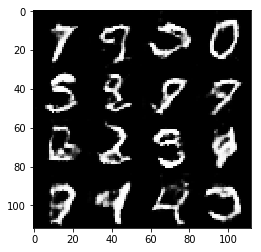

Epoch 0/2... Discriminator loss: 0.9335... Generator loss: 1.1107
Epoch 0/2... Discriminator loss: 1.3952... Generator loss: 0.7559
Epoch 0/2... Discriminator loss: 1.1368... Generator loss: 1.1169
Epoch 0/2... Discriminator loss: 1.0121... Generator loss: 1.0389
Epoch 0/2... Discriminator loss: 1.4472... Generator loss: 0.6391
Epoch 0/2... Discriminator loss: 1.0360... Generator loss: 1.3186
Epoch 0/2... Discriminator loss: 1.0772... Generator loss: 1.2487
Epoch 0/2... Discriminator loss: 1.0413... Generator loss: 1.3656
Epoch 0/2... Discriminator loss: 1.0085... Generator loss: 1.3198
Epoch 0/2... Discriminator loss: 1.3564... Generator loss: 0.6599


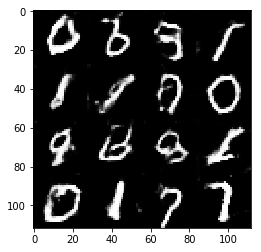

Epoch 0/2... Discriminator loss: 1.2255... Generator loss: 1.2758
Epoch 0/2... Discriminator loss: 1.3747... Generator loss: 1.6687
Epoch 0/2... Discriminator loss: 1.3138... Generator loss: 0.8839
Epoch 0/2... Discriminator loss: 1.1779... Generator loss: 1.2801
Epoch 0/2... Discriminator loss: 1.1161... Generator loss: 0.8677
Epoch 0/2... Discriminator loss: 1.4473... Generator loss: 0.6988
Epoch 0/2... Discriminator loss: 1.0325... Generator loss: 1.3147
Epoch 0/2... Discriminator loss: 1.4360... Generator loss: 0.7996
Epoch 0/2... Discriminator loss: 1.3861... Generator loss: 2.0986
Epoch 0/2... Discriminator loss: 1.1740... Generator loss: 1.0045


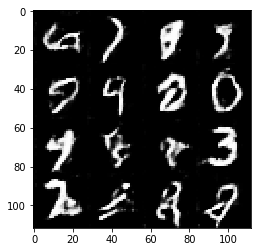

Epoch 0/2... Discriminator loss: 1.1428... Generator loss: 0.9158
Epoch 0/2... Discriminator loss: 1.0760... Generator loss: 1.2707
Epoch 0/2... Discriminator loss: 0.8933... Generator loss: 1.2144
Epoch 0/2... Discriminator loss: 0.9665... Generator loss: 1.4067
Epoch 0/2... Discriminator loss: 1.0842... Generator loss: 1.0698
Epoch 0/2... Discriminator loss: 1.1216... Generator loss: 1.4100
Epoch 0/2... Discriminator loss: 1.0945... Generator loss: 0.9282
Epoch 1/2... Discriminator loss: 1.0692... Generator loss: 0.8438
Epoch 1/2... Discriminator loss: 1.0615... Generator loss: 1.0992
Epoch 1/2... Discriminator loss: 1.0126... Generator loss: 1.4959


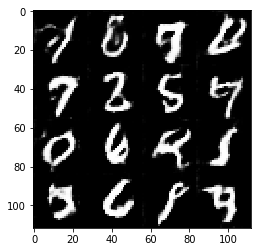

Epoch 1/2... Discriminator loss: 1.0792... Generator loss: 0.9539
Epoch 1/2... Discriminator loss: 1.2204... Generator loss: 1.7701
Epoch 1/2... Discriminator loss: 1.0960... Generator loss: 0.9374
Epoch 1/2... Discriminator loss: 1.2250... Generator loss: 1.6644
Epoch 1/2... Discriminator loss: 1.0522... Generator loss: 1.1731
Epoch 1/2... Discriminator loss: 1.4690... Generator loss: 0.8564
Epoch 1/2... Discriminator loss: 1.0968... Generator loss: 1.1994
Epoch 1/2... Discriminator loss: 1.3776... Generator loss: 0.7269
Epoch 1/2... Discriminator loss: 1.0884... Generator loss: 0.8800
Epoch 1/2... Discriminator loss: 1.2376... Generator loss: 1.3098


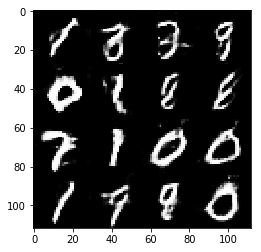

Epoch 1/2... Discriminator loss: 1.1212... Generator loss: 0.8351
Epoch 1/2... Discriminator loss: 1.0878... Generator loss: 0.7544
Epoch 1/2... Discriminator loss: 1.0414... Generator loss: 1.3802
Epoch 1/2... Discriminator loss: 1.2656... Generator loss: 1.5331
Epoch 1/2... Discriminator loss: 1.0334... Generator loss: 1.5692
Epoch 1/2... Discriminator loss: 0.9365... Generator loss: 1.3047
Epoch 1/2... Discriminator loss: 0.9932... Generator loss: 1.3657
Epoch 1/2... Discriminator loss: 1.0140... Generator loss: 1.0714
Epoch 1/2... Discriminator loss: 1.0620... Generator loss: 1.5669
Epoch 1/2... Discriminator loss: 1.1659... Generator loss: 0.8339


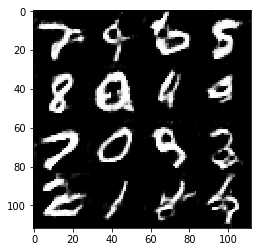

Epoch 1/2... Discriminator loss: 1.1534... Generator loss: 1.4973
Epoch 1/2... Discriminator loss: 1.3978... Generator loss: 0.7135
Epoch 1/2... Discriminator loss: 1.2511... Generator loss: 1.2581
Epoch 1/2... Discriminator loss: 1.7387... Generator loss: 0.5220
Epoch 1/2... Discriminator loss: 1.2791... Generator loss: 0.9462
Epoch 1/2... Discriminator loss: 1.2418... Generator loss: 0.7647
Epoch 1/2... Discriminator loss: 1.2452... Generator loss: 1.2577
Epoch 1/2... Discriminator loss: 1.0823... Generator loss: 1.1497
Epoch 1/2... Discriminator loss: 1.1096... Generator loss: 1.1271
Epoch 1/2... Discriminator loss: 1.3066... Generator loss: 0.9531


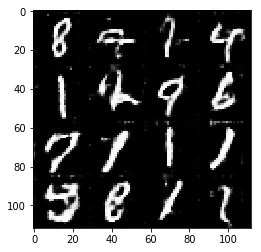

Epoch 1/2... Discriminator loss: 1.1628... Generator loss: 0.7673
Epoch 1/2... Discriminator loss: 1.0740... Generator loss: 1.4677
Epoch 1/2... Discriminator loss: 1.3133... Generator loss: 0.9795
Epoch 1/2... Discriminator loss: 1.2887... Generator loss: 0.8005
Epoch 1/2... Discriminator loss: 1.4108... Generator loss: 0.9251
Epoch 1/2... Discriminator loss: 1.2532... Generator loss: 1.7319
Epoch 1/2... Discriminator loss: 1.0984... Generator loss: 1.2817
Epoch 1/2... Discriminator loss: 1.0456... Generator loss: 1.8842
Epoch 1/2... Discriminator loss: 0.9079... Generator loss: 1.0575
Epoch 1/2... Discriminator loss: 1.0483... Generator loss: 1.1524


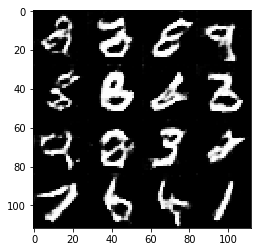

Epoch 1/2... Discriminator loss: 1.0862... Generator loss: 0.6995
Epoch 1/2... Discriminator loss: 0.9659... Generator loss: 1.2991
Epoch 1/2... Discriminator loss: 1.0599... Generator loss: 1.6531
Epoch 1/2... Discriminator loss: 0.9910... Generator loss: 1.1181
Epoch 1/2... Discriminator loss: 1.5101... Generator loss: 0.7456
Epoch 1/2... Discriminator loss: 1.1788... Generator loss: 1.7734
Epoch 1/2... Discriminator loss: 1.1793... Generator loss: 2.0690
Epoch 1/2... Discriminator loss: 1.3782... Generator loss: 1.4342
Epoch 1/2... Discriminator loss: 1.3271... Generator loss: 1.8753
Epoch 1/2... Discriminator loss: 1.1808... Generator loss: 0.7756


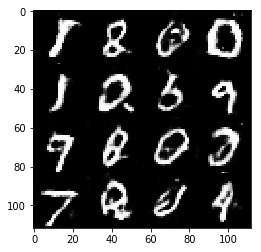

Epoch 1/2... Discriminator loss: 1.0511... Generator loss: 1.7010
Epoch 1/2... Discriminator loss: 0.9280... Generator loss: 1.4000
Epoch 1/2... Discriminator loss: 1.0634... Generator loss: 1.2669
Epoch 1/2... Discriminator loss: 1.0756... Generator loss: 1.1402
Epoch 1/2... Discriminator loss: 1.0111... Generator loss: 1.2034
Epoch 1/2... Discriminator loss: 1.0827... Generator loss: 0.8889
Epoch 1/2... Discriminator loss: 0.9624... Generator loss: 1.4898
Epoch 1/2... Discriminator loss: 1.3253... Generator loss: 1.9731
Epoch 1/2... Discriminator loss: 1.2171... Generator loss: 0.9941
Epoch 1/2... Discriminator loss: 1.3237... Generator loss: 0.9818


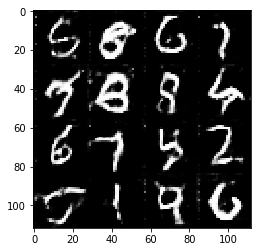

Epoch 1/2... Discriminator loss: 1.5747... Generator loss: 0.7459
Epoch 1/2... Discriminator loss: 1.0671... Generator loss: 1.1200
Epoch 1/2... Discriminator loss: 1.2244... Generator loss: 1.4433
Epoch 1/2... Discriminator loss: 1.2341... Generator loss: 0.7823
Epoch 1/2... Discriminator loss: 1.0223... Generator loss: 1.1917
Epoch 1/2... Discriminator loss: 1.1816... Generator loss: 1.0990
Epoch 1/2... Discriminator loss: 0.9632... Generator loss: 0.8464
Epoch 1/2... Discriminator loss: 0.9644... Generator loss: 1.7847
Epoch 1/2... Discriminator loss: 1.1508... Generator loss: 1.2684
Epoch 1/2... Discriminator loss: 1.0069... Generator loss: 1.4807


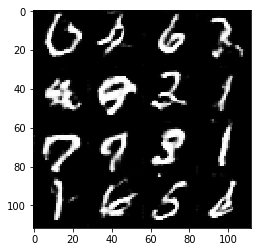

Epoch 1/2... Discriminator loss: 1.1396... Generator loss: 1.0438
Epoch 1/2... Discriminator loss: 1.0227... Generator loss: 1.3012
Epoch 1/2... Discriminator loss: 1.2501... Generator loss: 0.7964
Epoch 1/2... Discriminator loss: 1.1312... Generator loss: 1.6532
Epoch 1/2... Discriminator loss: 0.9398... Generator loss: 1.4066
Epoch 1/2... Discriminator loss: 0.8523... Generator loss: 1.5184
Epoch 1/2... Discriminator loss: 1.4547... Generator loss: 0.8298
Epoch 1/2... Discriminator loss: 1.1477... Generator loss: 0.7889
Epoch 1/2... Discriminator loss: 1.0871... Generator loss: 1.2409
Epoch 1/2... Discriminator loss: 1.1557... Generator loss: 1.2259


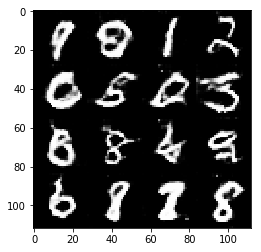

Epoch 1/2... Discriminator loss: 1.3127... Generator loss: 1.0643
Epoch 1/2... Discriminator loss: 1.0630... Generator loss: 1.5307
Epoch 1/2... Discriminator loss: 0.9608... Generator loss: 1.2862
Epoch 1/2... Discriminator loss: 1.0991... Generator loss: 1.7777
Epoch 1/2... Discriminator loss: 0.7591... Generator loss: 1.3726
Epoch 1/2... Discriminator loss: 1.2181... Generator loss: 0.9522
Epoch 1/2... Discriminator loss: 1.0748... Generator loss: 2.0274
Epoch 1/2... Discriminator loss: 0.8220... Generator loss: 1.7488
Epoch 1/2... Discriminator loss: 1.0097... Generator loss: 1.5354
Epoch 1/2... Discriminator loss: 0.7937... Generator loss: 1.7561


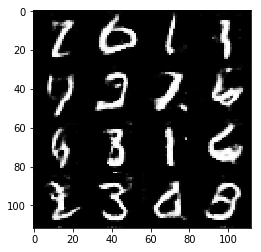

Epoch 1/2... Discriminator loss: 1.1766... Generator loss: 1.0068
Epoch 1/2... Discriminator loss: 1.1341... Generator loss: 1.6573
Epoch 1/2... Discriminator loss: 1.1164... Generator loss: 0.9672
Epoch 1/2... Discriminator loss: 0.9594... Generator loss: 1.5744
Epoch 1/2... Discriminator loss: 0.9444... Generator loss: 2.7728
Epoch 1/2... Discriminator loss: 0.9029... Generator loss: 2.0580
Epoch 1/2... Discriminator loss: 1.1851... Generator loss: 1.0393
Epoch 1/2... Discriminator loss: 1.0839... Generator loss: 1.9711
Epoch 1/2... Discriminator loss: 0.9624... Generator loss: 1.1066
Epoch 1/2... Discriminator loss: 0.7412... Generator loss: 1.7220


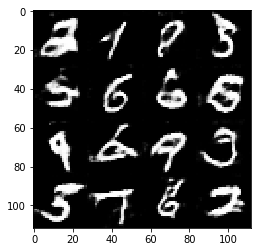

Epoch 1/2... Discriminator loss: 0.9001... Generator loss: 1.9342
Epoch 1/2... Discriminator loss: 1.0494... Generator loss: 0.8944
Epoch 1/2... Discriminator loss: 0.9972... Generator loss: 1.7560
Epoch 1/2... Discriminator loss: 1.1680... Generator loss: 1.1433
Epoch 1/2... Discriminator loss: 1.1949... Generator loss: 2.0141
Epoch 1/2... Discriminator loss: 0.8076... Generator loss: 1.5740
Epoch 1/2... Discriminator loss: 1.2518... Generator loss: 0.7615
Epoch 1/2... Discriminator loss: 1.0421... Generator loss: 1.5666
Epoch 1/2... Discriminator loss: 0.8686... Generator loss: 1.7089
Epoch 1/2... Discriminator loss: 0.9587... Generator loss: 1.3280


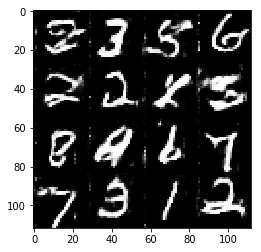

Epoch 1/2... Discriminator loss: 1.1445... Generator loss: 1.6831
Epoch 1/2... Discriminator loss: 0.8420... Generator loss: 1.3820
Epoch 1/2... Discriminator loss: 0.9737... Generator loss: 1.6250
Epoch 1/2... Discriminator loss: 0.9660... Generator loss: 1.4605
Epoch 1/2... Discriminator loss: 0.9896... Generator loss: 1.2033
Epoch 1/2... Discriminator loss: 1.0043... Generator loss: 1.2147
Epoch 1/2... Discriminator loss: 0.8744... Generator loss: 2.1375
Epoch 1/2... Discriminator loss: 0.6859... Generator loss: 1.9661
Epoch 1/2... Discriminator loss: 1.3548... Generator loss: 2.2645
Epoch 1/2... Discriminator loss: 1.0387... Generator loss: 1.1016


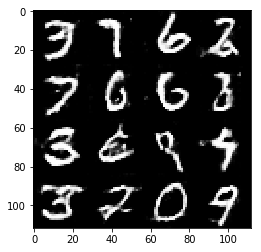

Epoch 1/2... Discriminator loss: 0.9861... Generator loss: 1.0612
Epoch 1/2... Discriminator loss: 1.2817... Generator loss: 0.8031
Epoch 1/2... Discriminator loss: 0.8515... Generator loss: 1.1839
Epoch 1/2... Discriminator loss: 0.8962... Generator loss: 1.4898
Epoch 1/2... Discriminator loss: 1.0498... Generator loss: 1.7376
Epoch 1/2... Discriminator loss: 0.7894... Generator loss: 1.2285
Epoch 1/2... Discriminator loss: 1.2990... Generator loss: 0.9436
Epoch 1/2... Discriminator loss: 1.3904... Generator loss: 2.3862
Epoch 1/2... Discriminator loss: 1.1219... Generator loss: 0.9456
Epoch 1/2... Discriminator loss: 0.9856... Generator loss: 1.3758


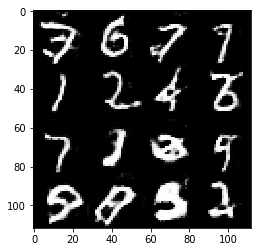

Epoch 1/2... Discriminator loss: 1.0183... Generator loss: 0.8975
Epoch 1/2... Discriminator loss: 1.1292... Generator loss: 1.2339
Epoch 1/2... Discriminator loss: 0.9328... Generator loss: 0.7447
Epoch 1/2... Discriminator loss: 1.2406... Generator loss: 0.9370
Epoch 1/2... Discriminator loss: 0.9765... Generator loss: 1.1773
Epoch 1/2... Discriminator loss: 0.9917... Generator loss: 1.4568
Epoch 1/2... Discriminator loss: 0.9099... Generator loss: 2.2609
Epoch 1/2... Discriminator loss: 1.2136... Generator loss: 0.9458
Epoch 1/2... Discriminator loss: 1.0436... Generator loss: 0.9700
Epoch 1/2... Discriminator loss: 0.8154... Generator loss: 1.3419


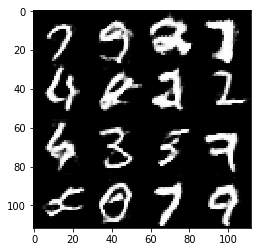

Epoch 1/2... Discriminator loss: 0.9993... Generator loss: 1.2898
Epoch 1/2... Discriminator loss: 0.8109... Generator loss: 2.2053
Epoch 1/2... Discriminator loss: 0.9157... Generator loss: 1.8444
Epoch 1/2... Discriminator loss: 1.0293... Generator loss: 2.0355
Epoch 1/2... Discriminator loss: 1.1343... Generator loss: 1.3583
Epoch 1/2... Discriminator loss: 1.0970... Generator loss: 1.1228
Epoch 1/2... Discriminator loss: 1.2136... Generator loss: 0.6209
Epoch 1/2... Discriminator loss: 0.9379... Generator loss: 1.1247
Epoch 1/2... Discriminator loss: 1.0467... Generator loss: 1.7385
Epoch 1/2... Discriminator loss: 0.8213... Generator loss: 0.9552


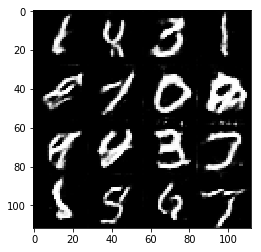

Epoch 1/2... Discriminator loss: 0.9683... Generator loss: 1.9352
Epoch 1/2... Discriminator loss: 0.7701... Generator loss: 1.7433
Epoch 1/2... Discriminator loss: 0.7130... Generator loss: 1.1874
Epoch 1/2... Discriminator loss: 1.1289... Generator loss: 0.9711
Epoch 1/2... Discriminator loss: 1.1327... Generator loss: 1.0549
Epoch 1/2... Discriminator loss: 0.9872... Generator loss: 1.6887
Epoch 1/2... Discriminator loss: 0.9232... Generator loss: 1.5084
Epoch 1/2... Discriminator loss: 1.1723... Generator loss: 1.5969
Epoch 1/2... Discriminator loss: 0.9400... Generator loss: 1.5949
Epoch 1/2... Discriminator loss: 0.8455... Generator loss: 1.8612


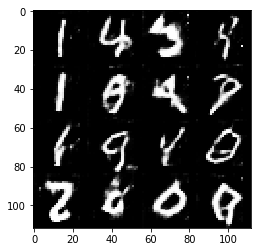

Epoch 1/2... Discriminator loss: 1.3579... Generator loss: 0.6645
Epoch 1/2... Discriminator loss: 1.0122... Generator loss: 1.7332
Epoch 1/2... Discriminator loss: 1.0435... Generator loss: 1.7068
Epoch 1/2... Discriminator loss: 0.8947... Generator loss: 1.2553
Epoch 1/2... Discriminator loss: 1.2777... Generator loss: 0.8298
Epoch 1/2... Discriminator loss: 1.3006... Generator loss: 0.7743
Epoch 1/2... Discriminator loss: 1.4732... Generator loss: 0.6972
Epoch 1/2... Discriminator loss: 0.9922... Generator loss: 1.3305
Epoch 1/2... Discriminator loss: 0.8098... Generator loss: 1.9092
Epoch 1/2... Discriminator loss: 1.0948... Generator loss: 3.0946


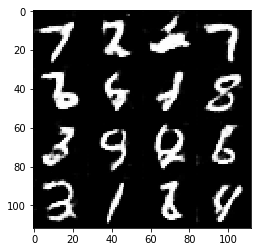

Epoch 1/2... Discriminator loss: 1.0370... Generator loss: 0.8728
Epoch 1/2... Discriminator loss: 1.1517... Generator loss: 1.4144
Epoch 1/2... Discriminator loss: 1.2298... Generator loss: 2.1944
Epoch 1/2... Discriminator loss: 0.9516... Generator loss: 1.6976
Epoch 1/2... Discriminator loss: 0.8677... Generator loss: 1.4144
Epoch 1/2... Discriminator loss: 0.8721... Generator loss: 1.3866
Epoch 1/2... Discriminator loss: 1.1622... Generator loss: 0.7746
Epoch 1/2... Discriminator loss: 0.8362... Generator loss: 2.3443
Epoch 1/2... Discriminator loss: 1.1032... Generator loss: 1.2414
Epoch 1/2... Discriminator loss: 0.9242... Generator loss: 0.8853


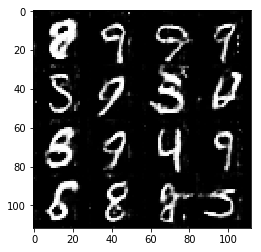

Epoch 1/2... Discriminator loss: 1.0102... Generator loss: 1.4278
Epoch 1/2... Discriminator loss: 0.8652... Generator loss: 1.3684
Epoch 1/2... Discriminator loss: 1.3313... Generator loss: 0.7170
Epoch 1/2... Discriminator loss: 0.8059... Generator loss: 1.4923
Epoch 1/2... Discriminator loss: 0.9646... Generator loss: 0.9843


In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/2... Discriminator loss: 1.6286... Generator loss: 0.5724
Epoch 0/2... Discriminator loss: 1.7161... Generator loss: 0.7670
Epoch 0/2... Discriminator loss: 1.6254... Generator loss: 0.8933
Epoch 0/2... Discriminator loss: 1.1680... Generator loss: 0.9742
Epoch 0/2... Discriminator loss: 1.2176... Generator loss: 1.2309
Epoch 0/2... Discriminator loss: 0.9455... Generator loss: 1.5834
Epoch 0/2... Discriminator loss: 1.1282... Generator loss: 1.1388
Epoch 0/2... Discriminator loss: 0.9609... Generator loss: 1.2322
Epoch 0/2... Discriminator loss: 0.9603... Generator loss: 1.0225
Epoch 0/2... Discriminator loss: 0.7846... Generator loss: 1.6152


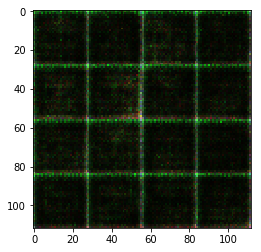

Epoch 0/2... Discriminator loss: 0.6639... Generator loss: 2.0387
Epoch 0/2... Discriminator loss: 0.6739... Generator loss: 2.0123
Epoch 0/2... Discriminator loss: 0.5181... Generator loss: 2.3369
Epoch 0/2... Discriminator loss: 0.6577... Generator loss: 2.0554
Epoch 0/2... Discriminator loss: 0.5693... Generator loss: 2.3125
Epoch 0/2... Discriminator loss: 0.5916... Generator loss: 2.1461
Epoch 0/2... Discriminator loss: 0.8174... Generator loss: 1.6720
Epoch 0/2... Discriminator loss: 0.6035... Generator loss: 2.0097
Epoch 0/2... Discriminator loss: 0.4854... Generator loss: 3.2019
Epoch 0/2... Discriminator loss: 0.5220... Generator loss: 2.4164


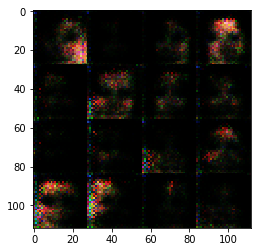

Epoch 0/2... Discriminator loss: 0.6585... Generator loss: 2.5210
Epoch 0/2... Discriminator loss: 1.0011... Generator loss: 3.9779
Epoch 0/2... Discriminator loss: 0.7030... Generator loss: 1.9832
Epoch 0/2... Discriminator loss: 0.6091... Generator loss: 2.2243
Epoch 0/2... Discriminator loss: 0.8889... Generator loss: 3.5864
Epoch 0/2... Discriminator loss: 0.8640... Generator loss: 1.8916
Epoch 0/2... Discriminator loss: 0.6180... Generator loss: 2.0857
Epoch 0/2... Discriminator loss: 0.9224... Generator loss: 3.2883
Epoch 0/2... Discriminator loss: 0.7718... Generator loss: 1.3933
Epoch 0/2... Discriminator loss: 0.9273... Generator loss: 3.7360


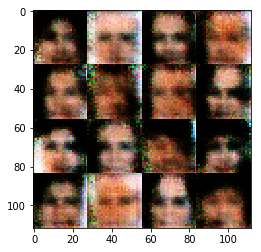

Epoch 0/2... Discriminator loss: 1.2789... Generator loss: 0.7472
Epoch 0/2... Discriminator loss: 0.8193... Generator loss: 1.1171
Epoch 0/2... Discriminator loss: 0.8142... Generator loss: 2.1479
Epoch 0/2... Discriminator loss: 1.0748... Generator loss: 1.0536
Epoch 0/2... Discriminator loss: 0.6988... Generator loss: 1.6878
Epoch 0/2... Discriminator loss: 0.9229... Generator loss: 2.0258
Epoch 0/2... Discriminator loss: 1.1701... Generator loss: 0.8296
Epoch 0/2... Discriminator loss: 0.8768... Generator loss: 1.9042
Epoch 0/2... Discriminator loss: 0.6871... Generator loss: 2.6228
Epoch 0/2... Discriminator loss: 0.8993... Generator loss: 2.5333


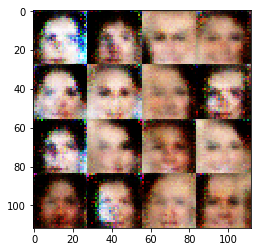

Epoch 0/2... Discriminator loss: 0.7455... Generator loss: 1.2349
Epoch 0/2... Discriminator loss: 0.9035... Generator loss: 1.9756
Epoch 0/2... Discriminator loss: 1.2668... Generator loss: 2.5093
Epoch 0/2... Discriminator loss: 1.0699... Generator loss: 1.1483
Epoch 0/2... Discriminator loss: 1.0481... Generator loss: 1.9255
Epoch 0/2... Discriminator loss: 1.4732... Generator loss: 0.9619
Epoch 0/2... Discriminator loss: 1.1328... Generator loss: 0.7526
Epoch 0/2... Discriminator loss: 1.3143... Generator loss: 1.5575
Epoch 0/2... Discriminator loss: 1.2673... Generator loss: 1.8630
Epoch 0/2... Discriminator loss: 1.0402... Generator loss: 1.1636


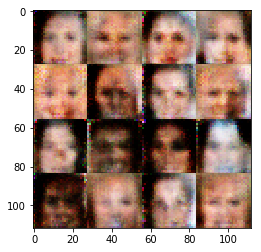

Epoch 0/2... Discriminator loss: 1.4243... Generator loss: 2.4214
Epoch 0/2... Discriminator loss: 1.1539... Generator loss: 1.3627
Epoch 0/2... Discriminator loss: 0.9784... Generator loss: 1.4940
Epoch 0/2... Discriminator loss: 0.9026... Generator loss: 1.1049
Epoch 0/2... Discriminator loss: 1.2749... Generator loss: 0.8510
Epoch 0/2... Discriminator loss: 1.4194... Generator loss: 1.7462
Epoch 0/2... Discriminator loss: 1.2392... Generator loss: 1.3376
Epoch 0/2... Discriminator loss: 0.9796... Generator loss: 1.5617
Epoch 0/2... Discriminator loss: 1.0282... Generator loss: 1.4073
Epoch 0/2... Discriminator loss: 1.1312... Generator loss: 1.1228


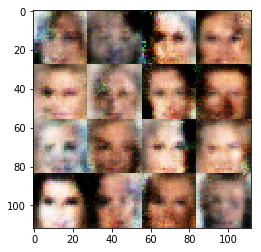

Epoch 0/2... Discriminator loss: 1.4401... Generator loss: 0.7590
Epoch 0/2... Discriminator loss: 1.1790... Generator loss: 1.2811
Epoch 0/2... Discriminator loss: 1.1577... Generator loss: 1.4422
Epoch 0/2... Discriminator loss: 1.2670... Generator loss: 2.0212
Epoch 0/2... Discriminator loss: 1.1384... Generator loss: 0.9515
Epoch 0/2... Discriminator loss: 1.1111... Generator loss: 1.0490
Epoch 0/2... Discriminator loss: 1.1483... Generator loss: 0.9875
Epoch 0/2... Discriminator loss: 1.2366... Generator loss: 0.7952
Epoch 0/2... Discriminator loss: 1.2914... Generator loss: 1.2360
Epoch 0/2... Discriminator loss: 1.0121... Generator loss: 1.0974


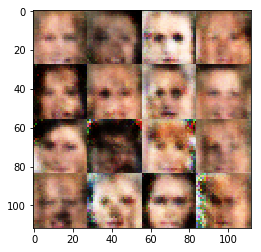

Epoch 0/2... Discriminator loss: 1.4195... Generator loss: 0.8192
Epoch 0/2... Discriminator loss: 1.4084... Generator loss: 0.5874
Epoch 0/2... Discriminator loss: 1.5069... Generator loss: 0.9474
Epoch 0/2... Discriminator loss: 1.3197... Generator loss: 0.9892
Epoch 0/2... Discriminator loss: 1.3259... Generator loss: 1.1914
Epoch 0/2... Discriminator loss: 1.1382... Generator loss: 1.2180
Epoch 0/2... Discriminator loss: 1.5011... Generator loss: 0.8737
Epoch 0/2... Discriminator loss: 1.1609... Generator loss: 1.3981
Epoch 0/2... Discriminator loss: 1.2744... Generator loss: 1.1967
Epoch 0/2... Discriminator loss: 1.3973... Generator loss: 0.8421


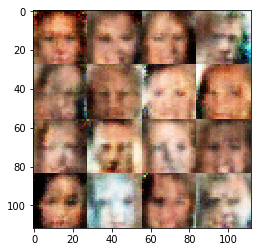

Epoch 0/2... Discriminator loss: 1.2805... Generator loss: 1.1377
Epoch 0/2... Discriminator loss: 1.3331... Generator loss: 0.8855
Epoch 0/2... Discriminator loss: 1.1816... Generator loss: 1.4314
Epoch 0/2... Discriminator loss: 1.2497... Generator loss: 0.9012
Epoch 0/2... Discriminator loss: 1.4322... Generator loss: 0.8457
Epoch 0/2... Discriminator loss: 1.4120... Generator loss: 0.9111
Epoch 0/2... Discriminator loss: 1.1802... Generator loss: 0.8324
Epoch 0/2... Discriminator loss: 1.2734... Generator loss: 1.1931
Epoch 0/2... Discriminator loss: 1.2794... Generator loss: 1.0496
Epoch 0/2... Discriminator loss: 1.5761... Generator loss: 0.7740


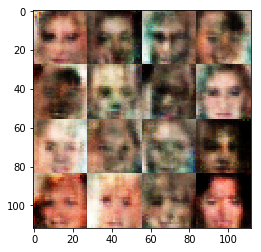

Epoch 0/2... Discriminator loss: 1.3809... Generator loss: 0.9009
Epoch 0/2... Discriminator loss: 1.3436... Generator loss: 0.7782
Epoch 0/2... Discriminator loss: 1.3492... Generator loss: 0.9182
Epoch 0/2... Discriminator loss: 1.2932... Generator loss: 0.8358
Epoch 0/2... Discriminator loss: 1.4120... Generator loss: 0.6225
Epoch 0/2... Discriminator loss: 1.2586... Generator loss: 0.9727
Epoch 0/2... Discriminator loss: 1.2629... Generator loss: 1.0534
Epoch 0/2... Discriminator loss: 1.3371... Generator loss: 0.8258
Epoch 0/2... Discriminator loss: 1.3586... Generator loss: 0.8249
Epoch 0/2... Discriminator loss: 1.3720... Generator loss: 0.6821


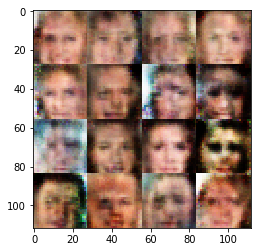

Epoch 0/2... Discriminator loss: 1.4236... Generator loss: 0.7961
Epoch 0/2... Discriminator loss: 1.4267... Generator loss: 0.6715
Epoch 0/2... Discriminator loss: 1.5109... Generator loss: 1.0827
Epoch 0/2... Discriminator loss: 1.6230... Generator loss: 0.6917
Epoch 0/2... Discriminator loss: 1.2793... Generator loss: 1.0694
Epoch 0/2... Discriminator loss: 1.4244... Generator loss: 0.8568
Epoch 0/2... Discriminator loss: 1.2966... Generator loss: 0.7673
Epoch 0/2... Discriminator loss: 1.5150... Generator loss: 0.9513
Epoch 0/2... Discriminator loss: 1.3463... Generator loss: 0.7805
Epoch 0/2... Discriminator loss: 1.3998... Generator loss: 1.0691


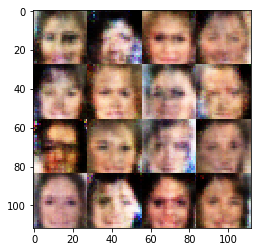

Epoch 0/2... Discriminator loss: 1.4735... Generator loss: 0.7433
Epoch 0/2... Discriminator loss: 1.4453... Generator loss: 0.7520
Epoch 0/2... Discriminator loss: 1.5061... Generator loss: 0.6902
Epoch 0/2... Discriminator loss: 1.3762... Generator loss: 0.9599
Epoch 0/2... Discriminator loss: 1.4680... Generator loss: 0.5684
Epoch 0/2... Discriminator loss: 1.4535... Generator loss: 0.6812
Epoch 0/2... Discriminator loss: 1.4742... Generator loss: 0.8507
Epoch 0/2... Discriminator loss: 1.5241... Generator loss: 0.9752
Epoch 0/2... Discriminator loss: 1.4849... Generator loss: 0.9690
Epoch 0/2... Discriminator loss: 1.4690... Generator loss: 0.8825


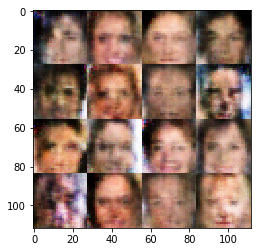

Epoch 0/2... Discriminator loss: 1.4085... Generator loss: 1.1284
Epoch 0/2... Discriminator loss: 1.4209... Generator loss: 0.9436
Epoch 0/2... Discriminator loss: 1.4100... Generator loss: 0.8817
Epoch 0/2... Discriminator loss: 1.4565... Generator loss: 0.8934
Epoch 0/2... Discriminator loss: 1.4769... Generator loss: 0.7483
Epoch 0/2... Discriminator loss: 1.3166... Generator loss: 1.2131
Epoch 0/2... Discriminator loss: 1.4677... Generator loss: 0.7482
Epoch 0/2... Discriminator loss: 1.2774... Generator loss: 1.1155
Epoch 0/2... Discriminator loss: 1.5663... Generator loss: 0.8422
Epoch 0/2... Discriminator loss: 1.3356... Generator loss: 1.1449


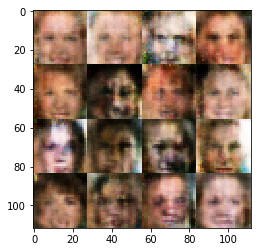

Epoch 0/2... Discriminator loss: 1.3843... Generator loss: 1.0649
Epoch 0/2... Discriminator loss: 1.4853... Generator loss: 0.8706
Epoch 0/2... Discriminator loss: 1.3392... Generator loss: 0.7882
Epoch 0/2... Discriminator loss: 1.4917... Generator loss: 0.9470
Epoch 0/2... Discriminator loss: 1.4322... Generator loss: 0.8914
Epoch 0/2... Discriminator loss: 1.4818... Generator loss: 0.8229
Epoch 0/2... Discriminator loss: 1.4671... Generator loss: 0.9661
Epoch 0/2... Discriminator loss: 1.4346... Generator loss: 0.8704
Epoch 0/2... Discriminator loss: 1.4580... Generator loss: 0.7143
Epoch 0/2... Discriminator loss: 1.3959... Generator loss: 0.8282


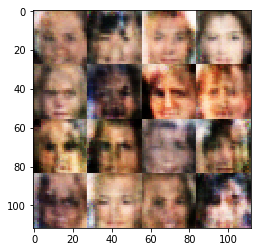

Epoch 0/2... Discriminator loss: 1.4332... Generator loss: 0.9287
Epoch 0/2... Discriminator loss: 1.5345... Generator loss: 0.7281
Epoch 0/2... Discriminator loss: 1.3587... Generator loss: 0.8728
Epoch 0/2... Discriminator loss: 1.4964... Generator loss: 0.7832
Epoch 0/2... Discriminator loss: 1.5996... Generator loss: 0.6420
Epoch 0/2... Discriminator loss: 1.5024... Generator loss: 0.8959
Epoch 0/2... Discriminator loss: 1.3978... Generator loss: 0.7616
Epoch 0/2... Discriminator loss: 1.3835... Generator loss: 0.8158
Epoch 0/2... Discriminator loss: 1.4803... Generator loss: 0.8459
Epoch 0/2... Discriminator loss: 1.5749... Generator loss: 0.7541


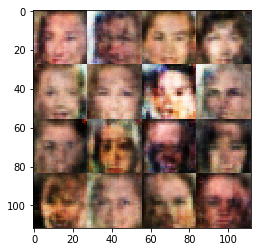

Epoch 0/2... Discriminator loss: 1.4469... Generator loss: 0.8248
Epoch 0/2... Discriminator loss: 1.4231... Generator loss: 0.7911
Epoch 0/2... Discriminator loss: 1.4048... Generator loss: 0.7602
Epoch 0/2... Discriminator loss: 1.4399... Generator loss: 0.7789
Epoch 0/2... Discriminator loss: 1.4841... Generator loss: 0.7575
Epoch 0/2... Discriminator loss: 1.3628... Generator loss: 0.8311
Epoch 0/2... Discriminator loss: 1.4517... Generator loss: 0.8192
Epoch 0/2... Discriminator loss: 1.4353... Generator loss: 0.8256
Epoch 0/2... Discriminator loss: 1.4387... Generator loss: 0.7855
Epoch 0/2... Discriminator loss: 1.3641... Generator loss: 0.8153


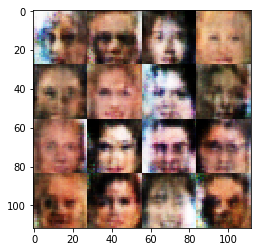

Epoch 0/2... Discriminator loss: 1.4911... Generator loss: 0.8247
Epoch 0/2... Discriminator loss: 1.4347... Generator loss: 0.7832
Epoch 0/2... Discriminator loss: 1.4479... Generator loss: 0.6641
Epoch 0/2... Discriminator loss: 1.4640... Generator loss: 0.9823
Epoch 0/2... Discriminator loss: 1.4556... Generator loss: 0.8383
Epoch 0/2... Discriminator loss: 1.4714... Generator loss: 0.8005
Epoch 0/2... Discriminator loss: 1.5387... Generator loss: 0.6817
Epoch 0/2... Discriminator loss: 1.4080... Generator loss: 0.8304
Epoch 0/2... Discriminator loss: 1.4395... Generator loss: 0.8714
Epoch 0/2... Discriminator loss: 1.4457... Generator loss: 0.7616


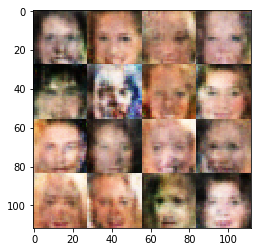

Epoch 0/2... Discriminator loss: 1.3424... Generator loss: 0.9491
Epoch 0/2... Discriminator loss: 1.4049... Generator loss: 0.8106
Epoch 0/2... Discriminator loss: 1.5072... Generator loss: 0.8304
Epoch 0/2... Discriminator loss: 1.5000... Generator loss: 0.7236
Epoch 0/2... Discriminator loss: 1.6559... Generator loss: 0.8510
Epoch 0/2... Discriminator loss: 1.5750... Generator loss: 0.7950
Epoch 0/2... Discriminator loss: 1.4705... Generator loss: 0.7955
Epoch 0/2... Discriminator loss: 1.3458... Generator loss: 0.7045
Epoch 0/2... Discriminator loss: 1.3422... Generator loss: 0.7527
Epoch 0/2... Discriminator loss: 1.4195... Generator loss: 0.7387


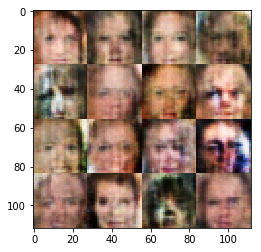

Epoch 0/2... Discriminator loss: 1.4719... Generator loss: 0.8046
Epoch 0/2... Discriminator loss: 1.3347... Generator loss: 0.8878
Epoch 0/2... Discriminator loss: 1.4442... Generator loss: 0.7759
Epoch 0/2... Discriminator loss: 1.4355... Generator loss: 0.8359
Epoch 0/2... Discriminator loss: 1.4619... Generator loss: 0.6957
Epoch 0/2... Discriminator loss: 1.2621... Generator loss: 0.8603
Epoch 0/2... Discriminator loss: 1.6327... Generator loss: 0.6734
Epoch 0/2... Discriminator loss: 1.4168... Generator loss: 0.9299
Epoch 0/2... Discriminator loss: 1.4166... Generator loss: 0.8141
Epoch 0/2... Discriminator loss: 1.2715... Generator loss: 0.8970


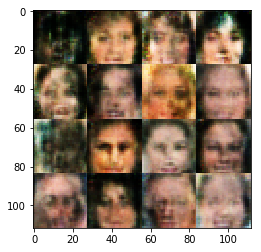

Epoch 0/2... Discriminator loss: 1.4321... Generator loss: 0.7529
Epoch 0/2... Discriminator loss: 1.3846... Generator loss: 0.7557
Epoch 0/2... Discriminator loss: 1.4744... Generator loss: 0.7619
Epoch 0/2... Discriminator loss: 1.4416... Generator loss: 0.8234
Epoch 0/2... Discriminator loss: 1.3500... Generator loss: 0.7929
Epoch 0/2... Discriminator loss: 1.4597... Generator loss: 0.8172
Epoch 0/2... Discriminator loss: 1.3791... Generator loss: 0.8661
Epoch 0/2... Discriminator loss: 1.4499... Generator loss: 0.7418
Epoch 0/2... Discriminator loss: 1.4041... Generator loss: 0.8589
Epoch 0/2... Discriminator loss: 1.5228... Generator loss: 0.8087


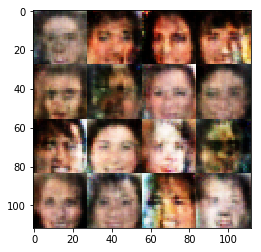

Epoch 0/2... Discriminator loss: 1.4117... Generator loss: 0.8654
Epoch 0/2... Discriminator loss: 1.4230... Generator loss: 0.7829
Epoch 0/2... Discriminator loss: 1.4186... Generator loss: 0.8968
Epoch 0/2... Discriminator loss: 1.2030... Generator loss: 1.0418
Epoch 0/2... Discriminator loss: 1.5569... Generator loss: 0.7421
Epoch 0/2... Discriminator loss: 1.3948... Generator loss: 0.8543
Epoch 0/2... Discriminator loss: 1.4634... Generator loss: 0.6722
Epoch 0/2... Discriminator loss: 1.3068... Generator loss: 0.8401
Epoch 0/2... Discriminator loss: 1.4702... Generator loss: 0.7270
Epoch 0/2... Discriminator loss: 1.4044... Generator loss: 0.8868


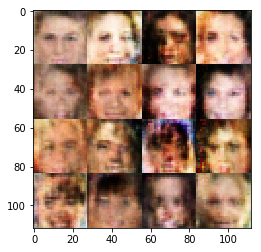

Epoch 0/2... Discriminator loss: 1.4970... Generator loss: 0.7108
Epoch 0/2... Discriminator loss: 1.4503... Generator loss: 0.7032
Epoch 0/2... Discriminator loss: 1.4362... Generator loss: 0.7919
Epoch 0/2... Discriminator loss: 1.4486... Generator loss: 0.7527
Epoch 0/2... Discriminator loss: 1.4625... Generator loss: 0.7389
Epoch 0/2... Discriminator loss: 1.4235... Generator loss: 0.7805
Epoch 0/2... Discriminator loss: 1.4421... Generator loss: 0.8201
Epoch 0/2... Discriminator loss: 1.3228... Generator loss: 0.7869
Epoch 0/2... Discriminator loss: 1.4413... Generator loss: 0.7073
Epoch 0/2... Discriminator loss: 1.4541... Generator loss: 0.7392


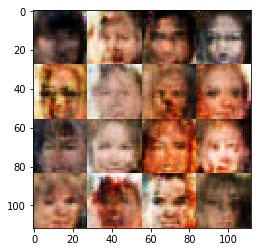

Epoch 0/2... Discriminator loss: 1.3783... Generator loss: 0.7973
Epoch 0/2... Discriminator loss: 1.5423... Generator loss: 0.7726
Epoch 0/2... Discriminator loss: 1.3864... Generator loss: 0.8480
Epoch 0/2... Discriminator loss: 1.3910... Generator loss: 0.8469
Epoch 0/2... Discriminator loss: 1.4021... Generator loss: 0.7750
Epoch 0/2... Discriminator loss: 1.4302... Generator loss: 0.7936
Epoch 0/2... Discriminator loss: 1.4515... Generator loss: 0.7508
Epoch 0/2... Discriminator loss: 1.4166... Generator loss: 0.6769
Epoch 0/2... Discriminator loss: 1.4336... Generator loss: 0.7858
Epoch 0/2... Discriminator loss: 1.3906... Generator loss: 0.8465


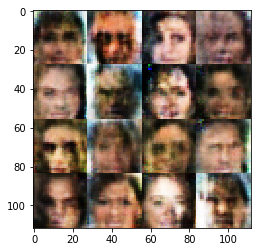

Epoch 0/2... Discriminator loss: 1.3952... Generator loss: 0.8579
Epoch 0/2... Discriminator loss: 1.4041... Generator loss: 0.7613
Epoch 0/2... Discriminator loss: 1.5081... Generator loss: 0.7207
Epoch 0/2... Discriminator loss: 1.4455... Generator loss: 0.7898
Epoch 0/2... Discriminator loss: 1.4675... Generator loss: 0.7598
Epoch 0/2... Discriminator loss: 1.3456... Generator loss: 0.6878
Epoch 0/2... Discriminator loss: 1.3203... Generator loss: 0.8730
Epoch 0/2... Discriminator loss: 1.4211... Generator loss: 0.8679
Epoch 0/2... Discriminator loss: 1.3947... Generator loss: 0.8060
Epoch 0/2... Discriminator loss: 1.3422... Generator loss: 0.8082


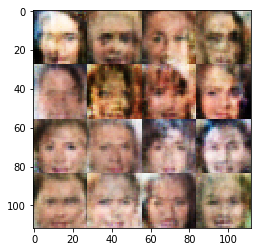

Epoch 0/2... Discriminator loss: 1.4692... Generator loss: 0.8374
Epoch 0/2... Discriminator loss: 1.3627... Generator loss: 0.8554
Epoch 0/2... Discriminator loss: 1.4352... Generator loss: 0.7706
Epoch 0/2... Discriminator loss: 1.4475... Generator loss: 0.8373
Epoch 0/2... Discriminator loss: 1.4270... Generator loss: 0.7913
Epoch 0/2... Discriminator loss: 1.3118... Generator loss: 0.8095
Epoch 0/2... Discriminator loss: 1.3457... Generator loss: 0.8023
Epoch 0/2... Discriminator loss: 1.3820... Generator loss: 0.7942
Epoch 0/2... Discriminator loss: 1.4754... Generator loss: 0.8867
Epoch 0/2... Discriminator loss: 1.3714... Generator loss: 0.8421


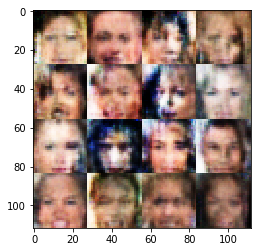

Epoch 0/2... Discriminator loss: 1.4525... Generator loss: 0.7419
Epoch 0/2... Discriminator loss: 1.4049... Generator loss: 0.7622
Epoch 0/2... Discriminator loss: 1.3888... Generator loss: 0.7471
Epoch 0/2... Discriminator loss: 1.2903... Generator loss: 0.7947
Epoch 0/2... Discriminator loss: 1.4478... Generator loss: 0.7620
Epoch 0/2... Discriminator loss: 1.3294... Generator loss: 0.8292
Epoch 0/2... Discriminator loss: 1.3802... Generator loss: 0.8305
Epoch 0/2... Discriminator loss: 1.4286... Generator loss: 0.7827
Epoch 0/2... Discriminator loss: 1.4061... Generator loss: 0.8310
Epoch 0/2... Discriminator loss: 1.4052... Generator loss: 0.7209


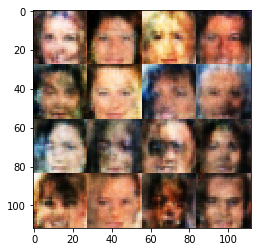

Epoch 0/2... Discriminator loss: 1.3479... Generator loss: 0.8671
Epoch 0/2... Discriminator loss: 1.4235... Generator loss: 0.8137
Epoch 0/2... Discriminator loss: 1.3907... Generator loss: 0.7528
Epoch 0/2... Discriminator loss: 1.3591... Generator loss: 0.8636
Epoch 0/2... Discriminator loss: 1.4794... Generator loss: 0.7509
Epoch 0/2... Discriminator loss: 1.4895... Generator loss: 0.6230
Epoch 0/2... Discriminator loss: 1.3796... Generator loss: 0.8010
Epoch 0/2... Discriminator loss: 1.3035... Generator loss: 0.8359
Epoch 0/2... Discriminator loss: 1.4452... Generator loss: 0.7209
Epoch 0/2... Discriminator loss: 1.3813... Generator loss: 0.8813


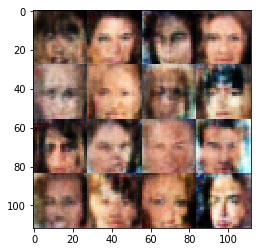

Epoch 0/2... Discriminator loss: 1.4535... Generator loss: 0.7724
Epoch 0/2... Discriminator loss: 1.3702... Generator loss: 0.7187
Epoch 0/2... Discriminator loss: 1.3838... Generator loss: 0.7172
Epoch 0/2... Discriminator loss: 1.3545... Generator loss: 0.8096
Epoch 0/2... Discriminator loss: 1.5971... Generator loss: 0.6869
Epoch 0/2... Discriminator loss: 1.3810... Generator loss: 0.8051
Epoch 0/2... Discriminator loss: 1.4584... Generator loss: 0.8138
Epoch 0/2... Discriminator loss: 1.5442... Generator loss: 0.7265
Epoch 0/2... Discriminator loss: 1.3693... Generator loss: 0.8012
Epoch 0/2... Discriminator loss: 1.3818... Generator loss: 0.8662


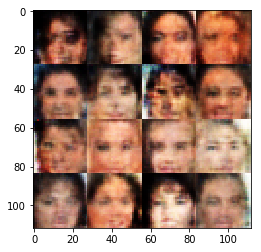

Epoch 0/2... Discriminator loss: 1.3813... Generator loss: 0.7159
Epoch 0/2... Discriminator loss: 1.3580... Generator loss: 0.8481
Epoch 0/2... Discriminator loss: 1.3760... Generator loss: 0.7600
Epoch 0/2... Discriminator loss: 1.3850... Generator loss: 0.7915
Epoch 0/2... Discriminator loss: 1.4765... Generator loss: 0.8165
Epoch 0/2... Discriminator loss: 1.4649... Generator loss: 0.6992
Epoch 0/2... Discriminator loss: 1.4114... Generator loss: 0.8460
Epoch 0/2... Discriminator loss: 1.4291... Generator loss: 0.7710
Epoch 0/2... Discriminator loss: 1.4140... Generator loss: 0.6996
Epoch 0/2... Discriminator loss: 1.3507... Generator loss: 0.8173


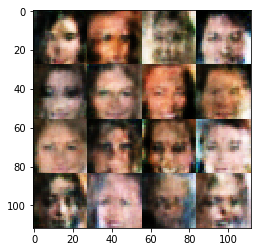

Epoch 0/2... Discriminator loss: 1.4153... Generator loss: 0.8817
Epoch 0/2... Discriminator loss: 1.3435... Generator loss: 0.7414
Epoch 0/2... Discriminator loss: 1.3871... Generator loss: 0.7526
Epoch 0/2... Discriminator loss: 1.4165... Generator loss: 0.7987
Epoch 0/2... Discriminator loss: 1.4424... Generator loss: 0.8082
Epoch 0/2... Discriminator loss: 1.4786... Generator loss: 0.6956
Epoch 0/2... Discriminator loss: 1.4041... Generator loss: 0.7817
Epoch 0/2... Discriminator loss: 1.2718... Generator loss: 0.8157
Epoch 0/2... Discriminator loss: 1.5251... Generator loss: 0.7329
Epoch 0/2... Discriminator loss: 1.4060... Generator loss: 0.8077


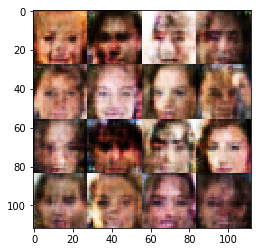

Epoch 0/2... Discriminator loss: 1.4122... Generator loss: 0.7712
Epoch 0/2... Discriminator loss: 1.3936... Generator loss: 0.8366
Epoch 0/2... Discriminator loss: 1.3474... Generator loss: 0.7762
Epoch 0/2... Discriminator loss: 1.4476... Generator loss: 0.7644
Epoch 0/2... Discriminator loss: 1.4724... Generator loss: 0.7550
Epoch 0/2... Discriminator loss: 1.3683... Generator loss: 0.8289
Epoch 0/2... Discriminator loss: 1.4091... Generator loss: 0.8254
Epoch 0/2... Discriminator loss: 1.3130... Generator loss: 0.9211
Epoch 0/2... Discriminator loss: 1.3528... Generator loss: 0.7787
Epoch 0/2... Discriminator loss: 1.4532... Generator loss: 0.7769


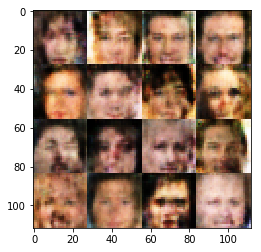

Epoch 0/2... Discriminator loss: 1.3756... Generator loss: 0.8650
Epoch 0/2... Discriminator loss: 1.4479... Generator loss: 0.7725
Epoch 0/2... Discriminator loss: 1.4031... Generator loss: 0.7739
Epoch 0/2... Discriminator loss: 1.5057... Generator loss: 0.6832
Epoch 0/2... Discriminator loss: 1.3972... Generator loss: 0.8351
Epoch 0/2... Discriminator loss: 1.3616... Generator loss: 0.7962
Epoch 0/2... Discriminator loss: 1.4268... Generator loss: 0.7661
Epoch 0/2... Discriminator loss: 1.3918... Generator loss: 0.7106
Epoch 0/2... Discriminator loss: 1.3994... Generator loss: 0.7682
Epoch 0/2... Discriminator loss: 1.3830... Generator loss: 0.8048


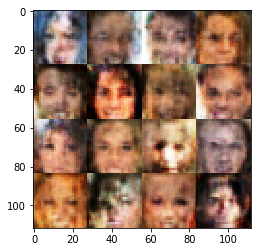

Epoch 0/2... Discriminator loss: 1.3769... Generator loss: 0.8656
Epoch 0/2... Discriminator loss: 1.4102... Generator loss: 0.7928
Epoch 0/2... Discriminator loss: 1.3870... Generator loss: 0.7853
Epoch 0/2... Discriminator loss: 1.4427... Generator loss: 0.7613
Epoch 0/2... Discriminator loss: 1.3986... Generator loss: 0.7316
Epoch 0/2... Discriminator loss: 1.4335... Generator loss: 0.8419
Epoch 0/2... Discriminator loss: 1.4636... Generator loss: 0.7314
Epoch 0/2... Discriminator loss: 1.4401... Generator loss: 0.7756
Epoch 0/2... Discriminator loss: 1.4760... Generator loss: 0.7980
Epoch 0/2... Discriminator loss: 1.3754... Generator loss: 0.8172


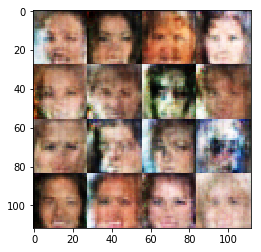

Epoch 0/2... Discriminator loss: 1.4487... Generator loss: 0.7512
Epoch 0/2... Discriminator loss: 1.4170... Generator loss: 0.6848
Epoch 0/2... Discriminator loss: 1.3521... Generator loss: 0.7911
Epoch 0/2... Discriminator loss: 1.5325... Generator loss: 0.7050
Epoch 0/2... Discriminator loss: 1.4181... Generator loss: 0.7288
Epoch 0/2... Discriminator loss: 1.3729... Generator loss: 0.7547
Epoch 0/2... Discriminator loss: 1.4439... Generator loss: 0.7104
Epoch 0/2... Discriminator loss: 1.3837... Generator loss: 0.7989
Epoch 0/2... Discriminator loss: 1.4285... Generator loss: 0.8493
Epoch 0/2... Discriminator loss: 1.3703... Generator loss: 0.7973


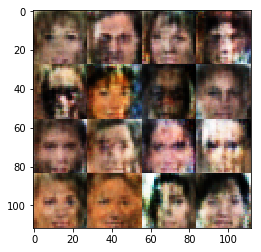

Epoch 0/2... Discriminator loss: 1.4519... Generator loss: 0.7872
Epoch 0/2... Discriminator loss: 1.4406... Generator loss: 0.8029
Epoch 0/2... Discriminator loss: 1.4455... Generator loss: 0.7618
Epoch 0/2... Discriminator loss: 1.4240... Generator loss: 0.7587
Epoch 0/2... Discriminator loss: 1.3288... Generator loss: 0.7989
Epoch 0/2... Discriminator loss: 1.5136... Generator loss: 0.7762
Epoch 0/2... Discriminator loss: 1.3703... Generator loss: 0.8120
Epoch 0/2... Discriminator loss: 1.3916... Generator loss: 0.9201
Epoch 0/2... Discriminator loss: 1.3826... Generator loss: 0.7697
Epoch 0/2... Discriminator loss: 1.4282... Generator loss: 0.8146


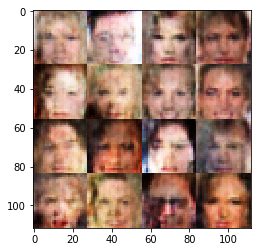

Epoch 0/2... Discriminator loss: 1.3485... Generator loss: 0.8694
Epoch 0/2... Discriminator loss: 1.4190... Generator loss: 0.8200
Epoch 0/2... Discriminator loss: 1.4151... Generator loss: 0.7388
Epoch 0/2... Discriminator loss: 1.4604... Generator loss: 0.7911
Epoch 0/2... Discriminator loss: 1.4047... Generator loss: 0.7986
Epoch 0/2... Discriminator loss: 1.3457... Generator loss: 0.7749
Epoch 0/2... Discriminator loss: 1.4244... Generator loss: 0.7774
Epoch 0/2... Discriminator loss: 1.4305... Generator loss: 0.7589
Epoch 0/2... Discriminator loss: 1.4229... Generator loss: 0.7373
Epoch 0/2... Discriminator loss: 1.3977... Generator loss: 0.8237


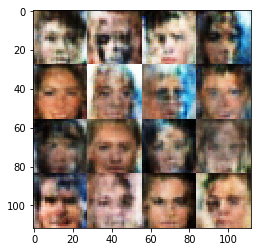

Epoch 0/2... Discriminator loss: 1.3867... Generator loss: 0.7561
Epoch 0/2... Discriminator loss: 1.3794... Generator loss: 0.7580
Epoch 0/2... Discriminator loss: 1.4310... Generator loss: 0.7533
Epoch 0/2... Discriminator loss: 1.3197... Generator loss: 0.8391
Epoch 0/2... Discriminator loss: 1.3174... Generator loss: 0.7943
Epoch 0/2... Discriminator loss: 1.3541... Generator loss: 0.8523
Epoch 0/2... Discriminator loss: 1.3739... Generator loss: 0.8319
Epoch 0/2... Discriminator loss: 1.3284... Generator loss: 0.8463
Epoch 0/2... Discriminator loss: 1.3540... Generator loss: 0.8661
Epoch 0/2... Discriminator loss: 1.4325... Generator loss: 0.7750


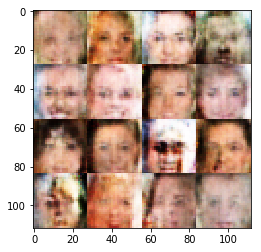

Epoch 0/2... Discriminator loss: 1.4385... Generator loss: 0.7420
Epoch 0/2... Discriminator loss: 1.3888... Generator loss: 0.7546
Epoch 0/2... Discriminator loss: 1.3693... Generator loss: 0.8199
Epoch 0/2... Discriminator loss: 1.4255... Generator loss: 0.7788
Epoch 0/2... Discriminator loss: 1.3913... Generator loss: 0.7907
Epoch 0/2... Discriminator loss: 1.4031... Generator loss: 0.8612
Epoch 0/2... Discriminator loss: 1.4169... Generator loss: 0.8554
Epoch 0/2... Discriminator loss: 1.4323... Generator loss: 0.7003
Epoch 0/2... Discriminator loss: 1.3534... Generator loss: 0.8162
Epoch 0/2... Discriminator loss: 1.3954... Generator loss: 0.8226


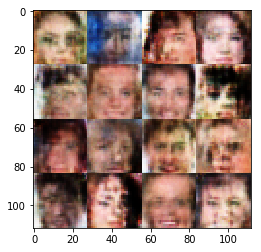

Epoch 0/2... Discriminator loss: 1.3975... Generator loss: 0.7761
Epoch 0/2... Discriminator loss: 1.3688... Generator loss: 0.8784
Epoch 0/2... Discriminator loss: 1.4044... Generator loss: 0.8045
Epoch 0/2... Discriminator loss: 1.4383... Generator loss: 0.7903
Epoch 0/2... Discriminator loss: 1.3761... Generator loss: 0.7981
Epoch 0/2... Discriminator loss: 1.4199... Generator loss: 0.7871
Epoch 0/2... Discriminator loss: 1.4347... Generator loss: 0.7914
Epoch 0/2... Discriminator loss: 1.3896... Generator loss: 0.7591
Epoch 0/2... Discriminator loss: 1.4099... Generator loss: 0.8045
Epoch 0/2... Discriminator loss: 1.3789... Generator loss: 0.8309


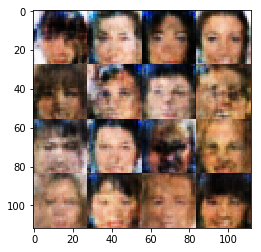

Epoch 0/2... Discriminator loss: 1.4499... Generator loss: 0.7622
Epoch 0/2... Discriminator loss: 1.3609... Generator loss: 0.8948
Epoch 0/2... Discriminator loss: 1.4104... Generator loss: 0.7188
Epoch 0/2... Discriminator loss: 1.3983... Generator loss: 0.8198
Epoch 0/2... Discriminator loss: 1.4345... Generator loss: 0.7944
Epoch 0/2... Discriminator loss: 1.3887... Generator loss: 0.8230
Epoch 0/2... Discriminator loss: 1.3259... Generator loss: 0.7988
Epoch 0/2... Discriminator loss: 1.3645... Generator loss: 0.9052
Epoch 0/2... Discriminator loss: 1.3303... Generator loss: 0.7917
Epoch 0/2... Discriminator loss: 1.4074... Generator loss: 0.8344


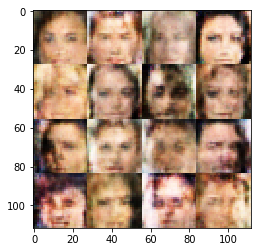

Epoch 0/2... Discriminator loss: 1.4335... Generator loss: 0.7385
Epoch 0/2... Discriminator loss: 1.4146... Generator loss: 0.7341
Epoch 0/2... Discriminator loss: 1.4249... Generator loss: 0.7451
Epoch 0/2... Discriminator loss: 1.4041... Generator loss: 0.8118
Epoch 0/2... Discriminator loss: 1.3845... Generator loss: 0.7509
Epoch 0/2... Discriminator loss: 1.3828... Generator loss: 0.7669
Epoch 0/2... Discriminator loss: 1.3956... Generator loss: 0.8543
Epoch 0/2... Discriminator loss: 1.4182... Generator loss: 0.7981
Epoch 0/2... Discriminator loss: 1.3287... Generator loss: 0.8057
Epoch 0/2... Discriminator loss: 1.3930... Generator loss: 0.7644


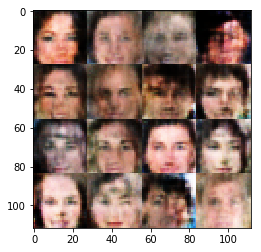

Epoch 0/2... Discriminator loss: 1.4050... Generator loss: 0.7557
Epoch 0/2... Discriminator loss: 1.3996... Generator loss: 0.7719
Epoch 0/2... Discriminator loss: 1.3763... Generator loss: 0.7778
Epoch 0/2... Discriminator loss: 1.3544... Generator loss: 0.9004
Epoch 0/2... Discriminator loss: 1.4295... Generator loss: 0.8042
Epoch 0/2... Discriminator loss: 1.3710... Generator loss: 0.7620
Epoch 0/2... Discriminator loss: 1.3333... Generator loss: 0.7858
Epoch 0/2... Discriminator loss: 1.3925... Generator loss: 0.7147
Epoch 0/2... Discriminator loss: 1.4486... Generator loss: 0.7459
Epoch 0/2... Discriminator loss: 1.3994... Generator loss: 0.7947


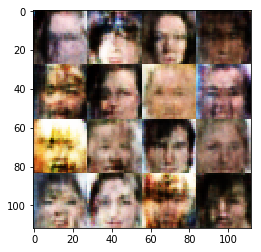

Epoch 0/2... Discriminator loss: 1.3831... Generator loss: 0.8559
Epoch 0/2... Discriminator loss: 1.4114... Generator loss: 0.7682
Epoch 0/2... Discriminator loss: 1.3773... Generator loss: 0.8217
Epoch 0/2... Discriminator loss: 1.3848... Generator loss: 0.7977
Epoch 0/2... Discriminator loss: 1.3866... Generator loss: 0.8114
Epoch 0/2... Discriminator loss: 1.4145... Generator loss: 0.8250
Epoch 0/2... Discriminator loss: 1.4256... Generator loss: 0.7554
Epoch 0/2... Discriminator loss: 1.3868... Generator loss: 0.7806
Epoch 0/2... Discriminator loss: 1.4431... Generator loss: 0.7521
Epoch 0/2... Discriminator loss: 1.3346... Generator loss: 0.7899


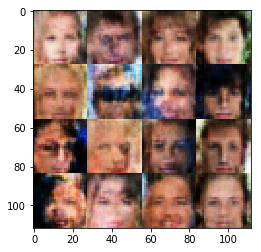

Epoch 0/2... Discriminator loss: 1.3837... Generator loss: 0.7904
Epoch 0/2... Discriminator loss: 1.4030... Generator loss: 0.8667
Epoch 0/2... Discriminator loss: 1.4134... Generator loss: 0.7520
Epoch 0/2... Discriminator loss: 1.3850... Generator loss: 0.8541
Epoch 0/2... Discriminator loss: 1.4290... Generator loss: 0.7497
Epoch 0/2... Discriminator loss: 1.4217... Generator loss: 0.7706
Epoch 0/2... Discriminator loss: 1.4264... Generator loss: 0.7611
Epoch 0/2... Discriminator loss: 1.4236... Generator loss: 0.8469
Epoch 0/2... Discriminator loss: 1.4219... Generator loss: 0.7862
Epoch 0/2... Discriminator loss: 1.3345... Generator loss: 0.8410


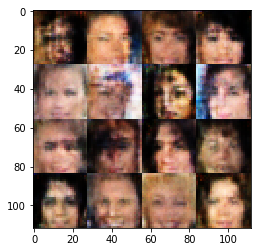

Epoch 0/2... Discriminator loss: 1.4422... Generator loss: 0.7361
Epoch 0/2... Discriminator loss: 1.4228... Generator loss: 0.7427
Epoch 0/2... Discriminator loss: 1.3745... Generator loss: 0.8066
Epoch 0/2... Discriminator loss: 1.3775... Generator loss: 0.7633
Epoch 0/2... Discriminator loss: 1.3687... Generator loss: 0.8061
Epoch 0/2... Discriminator loss: 1.3810... Generator loss: 0.7249
Epoch 0/2... Discriminator loss: 1.3278... Generator loss: 0.7541
Epoch 0/2... Discriminator loss: 1.3939... Generator loss: 0.8143
Epoch 0/2... Discriminator loss: 1.3787... Generator loss: 0.7618
Epoch 0/2... Discriminator loss: 1.3277... Generator loss: 0.7897


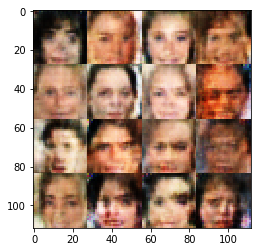

Epoch 0/2... Discriminator loss: 1.3606... Generator loss: 0.7928
Epoch 0/2... Discriminator loss: 1.3668... Generator loss: 0.7835
Epoch 0/2... Discriminator loss: 1.3622... Generator loss: 0.8627
Epoch 0/2... Discriminator loss: 1.3612... Generator loss: 0.8184
Epoch 0/2... Discriminator loss: 1.3191... Generator loss: 0.8273
Epoch 0/2... Discriminator loss: 1.3805... Generator loss: 0.7728
Epoch 0/2... Discriminator loss: 1.3658... Generator loss: 0.8452
Epoch 0/2... Discriminator loss: 1.3950... Generator loss: 0.7944
Epoch 0/2... Discriminator loss: 1.3073... Generator loss: 0.8557
Epoch 0/2... Discriminator loss: 1.3275... Generator loss: 0.8184


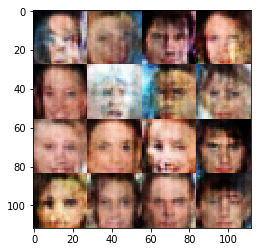

Epoch 0/2... Discriminator loss: 1.3205... Generator loss: 0.8089
Epoch 0/2... Discriminator loss: 1.4243... Generator loss: 0.7441
Epoch 0/2... Discriminator loss: 1.3698... Generator loss: 0.7710
Epoch 0/2... Discriminator loss: 1.3843... Generator loss: 0.8173
Epoch 0/2... Discriminator loss: 1.3873... Generator loss: 0.7715
Epoch 0/2... Discriminator loss: 1.3755... Generator loss: 0.8022
Epoch 0/2... Discriminator loss: 1.4097... Generator loss: 0.7953
Epoch 0/2... Discriminator loss: 1.3725... Generator loss: 0.8574
Epoch 0/2... Discriminator loss: 1.3704... Generator loss: 0.7963
Epoch 0/2... Discriminator loss: 1.3759... Generator loss: 0.8083


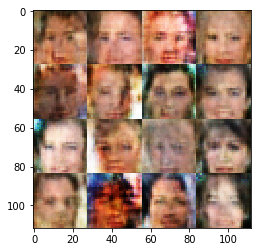

Epoch 0/2... Discriminator loss: 1.4152... Generator loss: 0.7735
Epoch 0/2... Discriminator loss: 1.4209... Generator loss: 0.7875
Epoch 0/2... Discriminator loss: 1.3532... Generator loss: 0.8438
Epoch 0/2... Discriminator loss: 1.3817... Generator loss: 0.8537
Epoch 0/2... Discriminator loss: 1.3700... Generator loss: 0.7689
Epoch 0/2... Discriminator loss: 1.3301... Generator loss: 0.8031
Epoch 0/2... Discriminator loss: 1.4084... Generator loss: 0.7869
Epoch 0/2... Discriminator loss: 1.3195... Generator loss: 0.8354
Epoch 0/2... Discriminator loss: 1.4131... Generator loss: 0.7556
Epoch 0/2... Discriminator loss: 1.3776... Generator loss: 0.8024


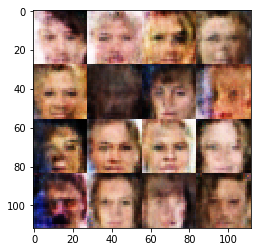

Epoch 0/2... Discriminator loss: 1.3995... Generator loss: 0.7806
Epoch 0/2... Discriminator loss: 1.4272... Generator loss: 0.7777
Epoch 0/2... Discriminator loss: 1.4133... Generator loss: 0.8288
Epoch 0/2... Discriminator loss: 1.3875... Generator loss: 0.7772
Epoch 0/2... Discriminator loss: 1.3558... Generator loss: 0.7750
Epoch 0/2... Discriminator loss: 1.3956... Generator loss: 0.8439
Epoch 0/2... Discriminator loss: 1.3794... Generator loss: 0.8263
Epoch 0/2... Discriminator loss: 1.3702... Generator loss: 0.7770
Epoch 0/2... Discriminator loss: 1.3800... Generator loss: 0.7583
Epoch 0/2... Discriminator loss: 1.3948... Generator loss: 0.8178


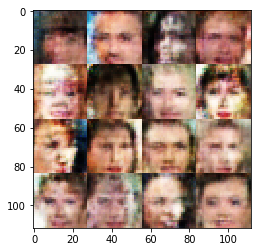

Epoch 0/2... Discriminator loss: 1.3827... Generator loss: 0.8085
Epoch 0/2... Discriminator loss: 1.3979... Generator loss: 0.7512
Epoch 0/2... Discriminator loss: 1.3718... Generator loss: 0.8150
Epoch 0/2... Discriminator loss: 1.4145... Generator loss: 0.8241
Epoch 0/2... Discriminator loss: 1.3491... Generator loss: 0.8313
Epoch 0/2... Discriminator loss: 1.3310... Generator loss: 0.8179
Epoch 0/2... Discriminator loss: 1.3920... Generator loss: 0.7667
Epoch 0/2... Discriminator loss: 1.4042... Generator loss: 0.7261
Epoch 0/2... Discriminator loss: 1.3937... Generator loss: 0.7871
Epoch 0/2... Discriminator loss: 1.3845... Generator loss: 0.7856


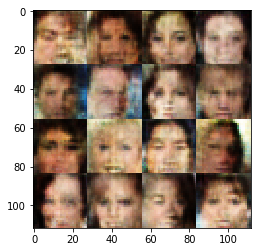

Epoch 0/2... Discriminator loss: 1.4264... Generator loss: 0.7584
Epoch 0/2... Discriminator loss: 1.3780... Generator loss: 0.7707
Epoch 0/2... Discriminator loss: 1.3659... Generator loss: 0.8181
Epoch 0/2... Discriminator loss: 1.3377... Generator loss: 0.7578
Epoch 0/2... Discriminator loss: 1.4245... Generator loss: 0.7712
Epoch 0/2... Discriminator loss: 1.3933... Generator loss: 0.8421
Epoch 0/2... Discriminator loss: 1.3464... Generator loss: 0.8323
Epoch 0/2... Discriminator loss: 1.4018... Generator loss: 0.7483
Epoch 0/2... Discriminator loss: 1.3679... Generator loss: 0.8435
Epoch 0/2... Discriminator loss: 1.3793... Generator loss: 0.7416


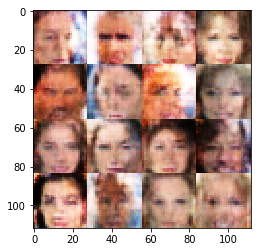

Epoch 0/2... Discriminator loss: 1.4197... Generator loss: 0.8265
Epoch 0/2... Discriminator loss: 1.4195... Generator loss: 0.7806
Epoch 0/2... Discriminator loss: 1.4030... Generator loss: 0.7912
Epoch 0/2... Discriminator loss: 1.3994... Generator loss: 0.8314
Epoch 0/2... Discriminator loss: 1.3918... Generator loss: 0.7444
Epoch 0/2... Discriminator loss: 1.3809... Generator loss: 0.8273
Epoch 0/2... Discriminator loss: 1.4048... Generator loss: 0.8039
Epoch 0/2... Discriminator loss: 1.3976... Generator loss: 0.7481
Epoch 0/2... Discriminator loss: 1.3519... Generator loss: 0.8039
Epoch 0/2... Discriminator loss: 1.4264... Generator loss: 0.7882


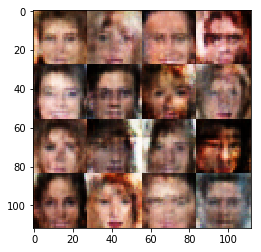

Epoch 0/2... Discriminator loss: 1.3865... Generator loss: 0.8110
Epoch 0/2... Discriminator loss: 1.4081... Generator loss: 0.8082
Epoch 0/2... Discriminator loss: 1.3857... Generator loss: 0.8046
Epoch 0/2... Discriminator loss: 1.3589... Generator loss: 0.7800
Epoch 0/2... Discriminator loss: 1.4308... Generator loss: 0.7993
Epoch 0/2... Discriminator loss: 1.3745... Generator loss: 0.7884
Epoch 0/2... Discriminator loss: 1.4303... Generator loss: 0.7664
Epoch 0/2... Discriminator loss: 1.3992... Generator loss: 0.7391
Epoch 0/2... Discriminator loss: 1.3702... Generator loss: 0.8179
Epoch 0/2... Discriminator loss: 1.4045... Generator loss: 0.8445


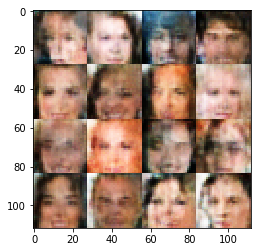

Epoch 0/2... Discriminator loss: 1.3588... Generator loss: 0.8464
Epoch 0/2... Discriminator loss: 1.4337... Generator loss: 0.7838
Epoch 0/2... Discriminator loss: 1.3790... Generator loss: 0.7620
Epoch 0/2... Discriminator loss: 1.3794... Generator loss: 0.8206
Epoch 0/2... Discriminator loss: 1.4022... Generator loss: 0.8182
Epoch 0/2... Discriminator loss: 1.3519... Generator loss: 0.8093
Epoch 0/2... Discriminator loss: 1.3825... Generator loss: 0.7659
Epoch 0/2... Discriminator loss: 1.4079... Generator loss: 0.8327
Epoch 0/2... Discriminator loss: 1.4264... Generator loss: 0.7587
Epoch 0/2... Discriminator loss: 1.4332... Generator loss: 0.7790


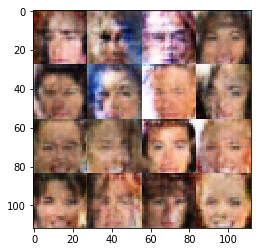

Epoch 0/2... Discriminator loss: 1.3571... Generator loss: 0.8007
Epoch 0/2... Discriminator loss: 1.3877... Generator loss: 0.8837
Epoch 0/2... Discriminator loss: 1.3801... Generator loss: 0.8077
Epoch 0/2... Discriminator loss: 1.3722... Generator loss: 0.7847
Epoch 0/2... Discriminator loss: 1.3721... Generator loss: 0.7659
Epoch 0/2... Discriminator loss: 1.3625... Generator loss: 0.7565
Epoch 0/2... Discriminator loss: 1.3421... Generator loss: 0.8272
Epoch 0/2... Discriminator loss: 1.4152... Generator loss: 0.7895
Epoch 0/2... Discriminator loss: 1.3493... Generator loss: 0.8346
Epoch 0/2... Discriminator loss: 1.3646... Generator loss: 0.7753


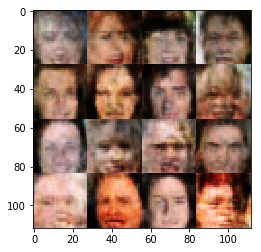

Epoch 0/2... Discriminator loss: 1.3714... Generator loss: 0.8134
Epoch 0/2... Discriminator loss: 1.4260... Generator loss: 0.7926
Epoch 0/2... Discriminator loss: 1.4052... Generator loss: 0.7552
Epoch 0/2... Discriminator loss: 1.4040... Generator loss: 0.7182
Epoch 0/2... Discriminator loss: 1.3932... Generator loss: 0.7863
Epoch 0/2... Discriminator loss: 1.3852... Generator loss: 0.8312
Epoch 0/2... Discriminator loss: 1.3943... Generator loss: 0.8089
Epoch 0/2... Discriminator loss: 1.3849... Generator loss: 0.7498
Epoch 0/2... Discriminator loss: 1.3887... Generator loss: 0.7624
Epoch 0/2... Discriminator loss: 1.3866... Generator loss: 0.8190


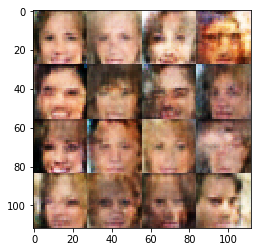

Epoch 0/2... Discriminator loss: 1.3506... Generator loss: 0.8321
Epoch 0/2... Discriminator loss: 1.4132... Generator loss: 0.7816
Epoch 0/2... Discriminator loss: 1.3870... Generator loss: 0.7767
Epoch 0/2... Discriminator loss: 1.3732... Generator loss: 0.7904
Epoch 0/2... Discriminator loss: 1.3562... Generator loss: 0.8028
Epoch 0/2... Discriminator loss: 1.3637... Generator loss: 0.8376
Epoch 0/2... Discriminator loss: 1.3618... Generator loss: 0.8257
Epoch 0/2... Discriminator loss: 1.3589... Generator loss: 0.8512
Epoch 0/2... Discriminator loss: 1.3386... Generator loss: 0.8289
Epoch 0/2... Discriminator loss: 1.3704... Generator loss: 0.7482


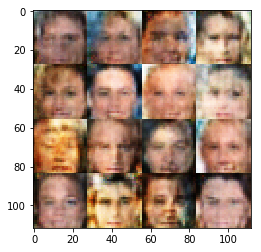

Epoch 0/2... Discriminator loss: 1.3841... Generator loss: 0.8511
Epoch 0/2... Discriminator loss: 1.4142... Generator loss: 0.7657
Epoch 0/2... Discriminator loss: 1.3580... Generator loss: 0.8059
Epoch 0/2... Discriminator loss: 1.3499... Generator loss: 0.8285
Epoch 0/2... Discriminator loss: 1.3824... Generator loss: 0.8442
Epoch 0/2... Discriminator loss: 1.3706... Generator loss: 0.8837
Epoch 0/2... Discriminator loss: 1.3732... Generator loss: 0.7924
Epoch 0/2... Discriminator loss: 1.3900... Generator loss: 0.8075
Epoch 0/2... Discriminator loss: 1.4279... Generator loss: 0.7236
Epoch 0/2... Discriminator loss: 1.4277... Generator loss: 0.7791


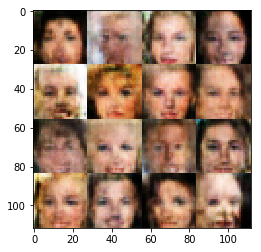

Epoch 0/2... Discriminator loss: 1.3394... Generator loss: 0.8116
Epoch 0/2... Discriminator loss: 1.3861... Generator loss: 0.8122
Epoch 0/2... Discriminator loss: 1.4152... Generator loss: 0.8317
Epoch 0/2... Discriminator loss: 1.4002... Generator loss: 0.7658
Epoch 0/2... Discriminator loss: 1.4070... Generator loss: 0.8097
Epoch 0/2... Discriminator loss: 1.3973... Generator loss: 0.8475
Epoch 0/2... Discriminator loss: 1.3875... Generator loss: 0.7423
Epoch 0/2... Discriminator loss: 1.3832... Generator loss: 0.7825
Epoch 0/2... Discriminator loss: 1.3799... Generator loss: 0.8024
Epoch 0/2... Discriminator loss: 1.3899... Generator loss: 0.8330


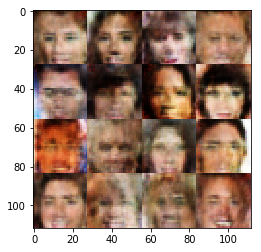

Epoch 0/2... Discriminator loss: 1.3709... Generator loss: 0.7106
Epoch 0/2... Discriminator loss: 1.3549... Generator loss: 0.7737
Epoch 0/2... Discriminator loss: 1.4104... Generator loss: 0.8120
Epoch 0/2... Discriminator loss: 1.3749... Generator loss: 0.7611
Epoch 0/2... Discriminator loss: 1.4245... Generator loss: 0.8571
Epoch 0/2... Discriminator loss: 1.3899... Generator loss: 0.8355
Epoch 0/2... Discriminator loss: 1.3998... Generator loss: 0.7870
Epoch 0/2... Discriminator loss: 1.3927... Generator loss: 0.7665
Epoch 0/2... Discriminator loss: 1.3757... Generator loss: 0.7969
Epoch 0/2... Discriminator loss: 1.4256... Generator loss: 0.7784


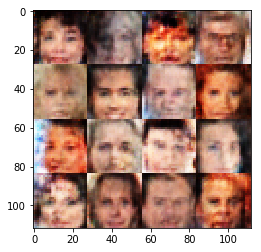

Epoch 0/2... Discriminator loss: 1.3587... Generator loss: 0.7706
Epoch 0/2... Discriminator loss: 1.4050... Generator loss: 0.8133
Epoch 0/2... Discriminator loss: 1.3789... Generator loss: 0.8162
Epoch 0/2... Discriminator loss: 1.3981... Generator loss: 0.8081
Epoch 0/2... Discriminator loss: 1.4429... Generator loss: 0.8010
Epoch 0/2... Discriminator loss: 1.3772... Generator loss: 0.7754
Epoch 0/2... Discriminator loss: 1.3561... Generator loss: 0.7458
Epoch 0/2... Discriminator loss: 1.4143... Generator loss: 0.7967
Epoch 0/2... Discriminator loss: 1.3905... Generator loss: 0.8287
Epoch 0/2... Discriminator loss: 1.3618... Generator loss: 0.8127


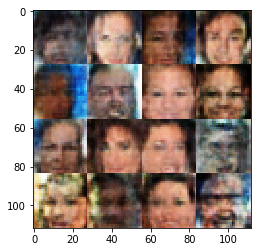

Epoch 0/2... Discriminator loss: 1.3622... Generator loss: 0.8395
Epoch 0/2... Discriminator loss: 1.3542... Generator loss: 0.7618
Epoch 0/2... Discriminator loss: 1.4092... Generator loss: 0.8193
Epoch 0/2... Discriminator loss: 1.3553... Generator loss: 0.8109
Epoch 0/2... Discriminator loss: 1.3799... Generator loss: 0.7832
Epoch 0/2... Discriminator loss: 1.3775... Generator loss: 0.7677
Epoch 0/2... Discriminator loss: 1.3946... Generator loss: 0.7859
Epoch 0/2... Discriminator loss: 1.3953... Generator loss: 0.7759
Epoch 0/2... Discriminator loss: 1.3747... Generator loss: 0.8076
Epoch 0/2... Discriminator loss: 1.3843... Generator loss: 0.7667


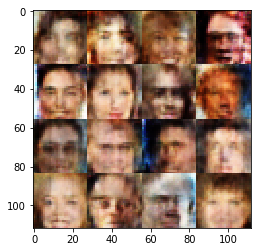

Epoch 0/2... Discriminator loss: 1.4304... Generator loss: 0.7847
Epoch 0/2... Discriminator loss: 1.3807... Generator loss: 0.7965
Epoch 0/2... Discriminator loss: 1.3701... Generator loss: 0.8011
Epoch 0/2... Discriminator loss: 1.3916... Generator loss: 0.7586
Epoch 0/2... Discriminator loss: 1.3880... Generator loss: 0.8103
Epoch 0/2... Discriminator loss: 1.4096... Generator loss: 0.7846
Epoch 0/2... Discriminator loss: 1.3345... Generator loss: 0.8282
Epoch 0/2... Discriminator loss: 1.4083... Generator loss: 0.7647
Epoch 0/2... Discriminator loss: 1.3624... Generator loss: 0.8033
Epoch 0/2... Discriminator loss: 1.3258... Generator loss: 0.8165


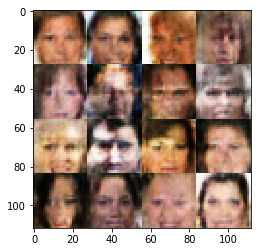

Epoch 0/2... Discriminator loss: 1.3737... Generator loss: 0.7869
Epoch 0/2... Discriminator loss: 1.4014... Generator loss: 0.7613
Epoch 0/2... Discriminator loss: 1.4230... Generator loss: 0.7623
Epoch 1/2... Discriminator loss: 1.3751... Generator loss: 0.8168
Epoch 1/2... Discriminator loss: 1.3684... Generator loss: 0.8128
Epoch 1/2... Discriminator loss: 1.3764... Generator loss: 0.7685
Epoch 1/2... Discriminator loss: 1.4224... Generator loss: 0.8316
Epoch 1/2... Discriminator loss: 1.3606... Generator loss: 0.8018
Epoch 1/2... Discriminator loss: 1.4301... Generator loss: 0.7878
Epoch 1/2... Discriminator loss: 1.3735... Generator loss: 0.8232


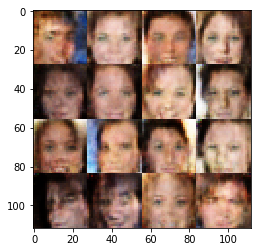

Epoch 1/2... Discriminator loss: 1.3834... Generator loss: 0.8105
Epoch 1/2... Discriminator loss: 1.3714... Generator loss: 0.8169
Epoch 1/2... Discriminator loss: 1.3926... Generator loss: 0.7803
Epoch 1/2... Discriminator loss: 1.3905... Generator loss: 0.7800
Epoch 1/2... Discriminator loss: 1.4131... Generator loss: 0.8044
Epoch 1/2... Discriminator loss: 1.3734... Generator loss: 0.7973
Epoch 1/2... Discriminator loss: 1.3735... Generator loss: 0.7614
Epoch 1/2... Discriminator loss: 1.3528... Generator loss: 0.7991
Epoch 1/2... Discriminator loss: 1.3434... Generator loss: 0.8037
Epoch 1/2... Discriminator loss: 1.3871... Generator loss: 0.7850


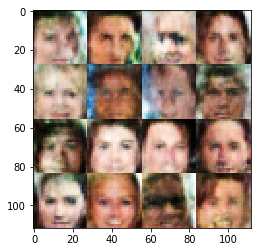

Epoch 1/2... Discriminator loss: 1.3185... Generator loss: 0.8161
Epoch 1/2... Discriminator loss: 1.3924... Generator loss: 0.8088
Epoch 1/2... Discriminator loss: 1.3830... Generator loss: 0.7689
Epoch 1/2... Discriminator loss: 1.3673... Generator loss: 0.8415
Epoch 1/2... Discriminator loss: 1.3906... Generator loss: 0.7428
Epoch 1/2... Discriminator loss: 1.3479... Generator loss: 0.8418
Epoch 1/2... Discriminator loss: 1.3796... Generator loss: 0.7607
Epoch 1/2... Discriminator loss: 1.3841... Generator loss: 0.7796
Epoch 1/2... Discriminator loss: 1.4311... Generator loss: 0.7773
Epoch 1/2... Discriminator loss: 1.4140... Generator loss: 0.7500


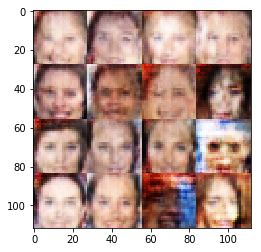

Epoch 1/2... Discriminator loss: 1.3881... Generator loss: 0.7790
Epoch 1/2... Discriminator loss: 1.4025... Generator loss: 0.7189
Epoch 1/2... Discriminator loss: 1.4040... Generator loss: 0.8234
Epoch 1/2... Discriminator loss: 1.4079... Generator loss: 0.7981
Epoch 1/2... Discriminator loss: 1.3900... Generator loss: 0.7795
Epoch 1/2... Discriminator loss: 1.3878... Generator loss: 0.7872
Epoch 1/2... Discriminator loss: 1.3593... Generator loss: 0.7753
Epoch 1/2... Discriminator loss: 1.3808... Generator loss: 0.7866
Epoch 1/2... Discriminator loss: 1.4086... Generator loss: 0.7856
Epoch 1/2... Discriminator loss: 1.4040... Generator loss: 0.7954


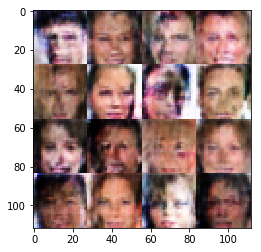

Epoch 1/2... Discriminator loss: 1.3812... Generator loss: 0.7935
Epoch 1/2... Discriminator loss: 1.3885... Generator loss: 0.7523
Epoch 1/2... Discriminator loss: 1.3621... Generator loss: 0.7865
Epoch 1/2... Discriminator loss: 1.3823... Generator loss: 0.7862
Epoch 1/2... Discriminator loss: 1.3857... Generator loss: 0.7709
Epoch 1/2... Discriminator loss: 1.3814... Generator loss: 0.8147
Epoch 1/2... Discriminator loss: 1.4080... Generator loss: 0.7652
Epoch 1/2... Discriminator loss: 1.3571... Generator loss: 0.8123
Epoch 1/2... Discriminator loss: 1.3826... Generator loss: 0.8010
Epoch 1/2... Discriminator loss: 1.3747... Generator loss: 0.7489


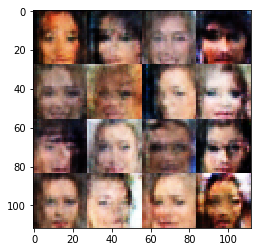

Epoch 1/2... Discriminator loss: 1.3867... Generator loss: 0.8064
Epoch 1/2... Discriminator loss: 1.4016... Generator loss: 0.7577
Epoch 1/2... Discriminator loss: 1.3724... Generator loss: 0.7837
Epoch 1/2... Discriminator loss: 1.3764... Generator loss: 0.7766
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 0.7963
Epoch 1/2... Discriminator loss: 1.4088... Generator loss: 0.7655
Epoch 1/2... Discriminator loss: 1.3638... Generator loss: 0.7901
Epoch 1/2... Discriminator loss: 1.3693... Generator loss: 0.8516
Epoch 1/2... Discriminator loss: 1.3876... Generator loss: 0.7420
Epoch 1/2... Discriminator loss: 1.3907... Generator loss: 0.7946


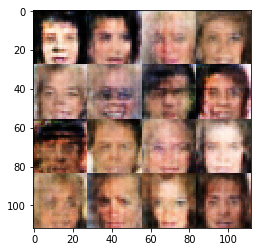

Epoch 1/2... Discriminator loss: 1.4290... Generator loss: 0.7109
Epoch 1/2... Discriminator loss: 1.3809... Generator loss: 0.7652
Epoch 1/2... Discriminator loss: 1.3821... Generator loss: 0.8052
Epoch 1/2... Discriminator loss: 1.3760... Generator loss: 0.7890
Epoch 1/2... Discriminator loss: 1.3810... Generator loss: 0.7893
Epoch 1/2... Discriminator loss: 1.3790... Generator loss: 0.7696
Epoch 1/2... Discriminator loss: 1.3818... Generator loss: 0.8079
Epoch 1/2... Discriminator loss: 1.4033... Generator loss: 0.8193
Epoch 1/2... Discriminator loss: 1.3561... Generator loss: 0.8153
Epoch 1/2... Discriminator loss: 1.4068... Generator loss: 0.7742


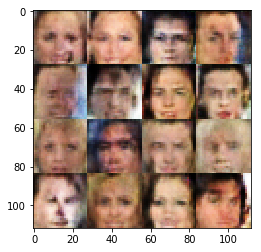

Epoch 1/2... Discriminator loss: 1.3735... Generator loss: 0.7524
Epoch 1/2... Discriminator loss: 1.4113... Generator loss: 0.7603
Epoch 1/2... Discriminator loss: 1.3632... Generator loss: 0.7838
Epoch 1/2... Discriminator loss: 1.4056... Generator loss: 0.7676
Epoch 1/2... Discriminator loss: 1.3873... Generator loss: 0.7408
Epoch 1/2... Discriminator loss: 1.3921... Generator loss: 0.8128
Epoch 1/2... Discriminator loss: 1.4178... Generator loss: 0.7780
Epoch 1/2... Discriminator loss: 1.3588... Generator loss: 0.7894
Epoch 1/2... Discriminator loss: 1.4107... Generator loss: 0.7890
Epoch 1/2... Discriminator loss: 1.3941... Generator loss: 0.7849


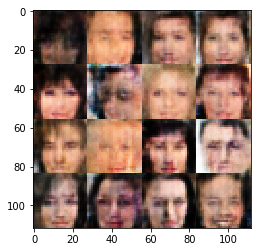

Epoch 1/2... Discriminator loss: 1.3889... Generator loss: 0.7811
Epoch 1/2... Discriminator loss: 1.3825... Generator loss: 0.7668
Epoch 1/2... Discriminator loss: 1.3829... Generator loss: 0.8367
Epoch 1/2... Discriminator loss: 1.3972... Generator loss: 0.7669
Epoch 1/2... Discriminator loss: 1.3735... Generator loss: 0.7982
Epoch 1/2... Discriminator loss: 1.3474... Generator loss: 0.8038
Epoch 1/2... Discriminator loss: 1.4217... Generator loss: 0.7920
Epoch 1/2... Discriminator loss: 1.3686... Generator loss: 0.8069
Epoch 1/2... Discriminator loss: 1.3514... Generator loss: 0.8421
Epoch 1/2... Discriminator loss: 1.3821... Generator loss: 0.7850


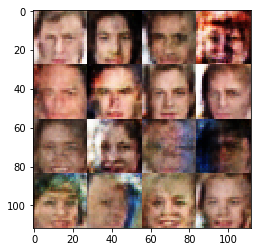

Epoch 1/2... Discriminator loss: 1.4195... Generator loss: 0.7820
Epoch 1/2... Discriminator loss: 1.3982... Generator loss: 0.8012
Epoch 1/2... Discriminator loss: 1.3945... Generator loss: 0.7917
Epoch 1/2... Discriminator loss: 1.3909... Generator loss: 0.7883
Epoch 1/2... Discriminator loss: 1.3857... Generator loss: 0.7937
Epoch 1/2... Discriminator loss: 1.3787... Generator loss: 0.7884
Epoch 1/2... Discriminator loss: 1.3824... Generator loss: 0.7991
Epoch 1/2... Discriminator loss: 1.3732... Generator loss: 0.7875
Epoch 1/2... Discriminator loss: 1.3962... Generator loss: 0.7684
Epoch 1/2... Discriminator loss: 1.3889... Generator loss: 0.8094


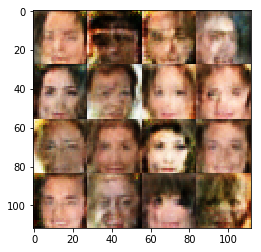

Epoch 1/2... Discriminator loss: 1.3942... Generator loss: 0.7584
Epoch 1/2... Discriminator loss: 1.3702... Generator loss: 0.8030
Epoch 1/2... Discriminator loss: 1.3687... Generator loss: 0.8047
Epoch 1/2... Discriminator loss: 1.4076... Generator loss: 0.7665
Epoch 1/2... Discriminator loss: 1.3838... Generator loss: 0.8405
Epoch 1/2... Discriminator loss: 1.4017... Generator loss: 0.7838
Epoch 1/2... Discriminator loss: 1.3682... Generator loss: 0.8247
Epoch 1/2... Discriminator loss: 1.3487... Generator loss: 0.8446
Epoch 1/2... Discriminator loss: 1.3628... Generator loss: 0.7763
Epoch 1/2... Discriminator loss: 1.4350... Generator loss: 0.8177


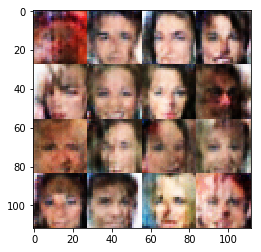

Epoch 1/2... Discriminator loss: 1.4039... Generator loss: 0.7748
Epoch 1/2... Discriminator loss: 1.3611... Generator loss: 0.8520
Epoch 1/2... Discriminator loss: 1.3966... Generator loss: 0.7928
Epoch 1/2... Discriminator loss: 1.3878... Generator loss: 0.8261
Epoch 1/2... Discriminator loss: 1.3905... Generator loss: 0.7744
Epoch 1/2... Discriminator loss: 1.3956... Generator loss: 0.8123
Epoch 1/2... Discriminator loss: 1.3748... Generator loss: 0.7967
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 0.7859
Epoch 1/2... Discriminator loss: 1.3872... Generator loss: 0.8158
Epoch 1/2... Discriminator loss: 1.3860... Generator loss: 0.7565


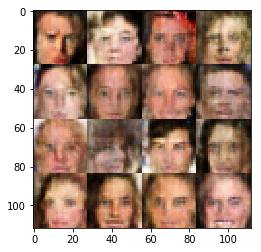

Epoch 1/2... Discriminator loss: 1.3806... Generator loss: 0.7910
Epoch 1/2... Discriminator loss: 1.3796... Generator loss: 0.8195
Epoch 1/2... Discriminator loss: 1.4164... Generator loss: 0.7509
Epoch 1/2... Discriminator loss: 1.3631... Generator loss: 0.7720
Epoch 1/2... Discriminator loss: 1.3791... Generator loss: 0.8209
Epoch 1/2... Discriminator loss: 1.4037... Generator loss: 0.7503
Epoch 1/2... Discriminator loss: 1.3709... Generator loss: 0.7934
Epoch 1/2... Discriminator loss: 1.3839... Generator loss: 0.7420
Epoch 1/2... Discriminator loss: 1.3882... Generator loss: 0.7802
Epoch 1/2... Discriminator loss: 1.3688... Generator loss: 0.7720


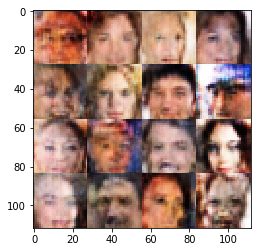

Epoch 1/2... Discriminator loss: 1.3758... Generator loss: 0.7366
Epoch 1/2... Discriminator loss: 1.4203... Generator loss: 0.8280
Epoch 1/2... Discriminator loss: 1.3445... Generator loss: 0.7742
Epoch 1/2... Discriminator loss: 1.4148... Generator loss: 0.8117
Epoch 1/2... Discriminator loss: 1.4280... Generator loss: 0.8079
Epoch 1/2... Discriminator loss: 1.3796... Generator loss: 0.7933
Epoch 1/2... Discriminator loss: 1.3572... Generator loss: 0.8090
Epoch 1/2... Discriminator loss: 1.3719... Generator loss: 0.8327
Epoch 1/2... Discriminator loss: 1.4187... Generator loss: 0.7907
Epoch 1/2... Discriminator loss: 1.4083... Generator loss: 0.7765


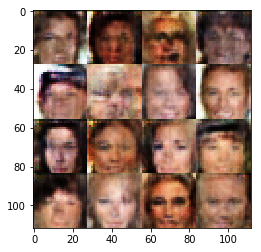

Epoch 1/2... Discriminator loss: 1.4035... Generator loss: 0.7867
Epoch 1/2... Discriminator loss: 1.3829... Generator loss: 0.7923
Epoch 1/2... Discriminator loss: 1.3996... Generator loss: 0.7539
Epoch 1/2... Discriminator loss: 1.3996... Generator loss: 0.7940
Epoch 1/2... Discriminator loss: 1.3639... Generator loss: 0.8021
Epoch 1/2... Discriminator loss: 1.3661... Generator loss: 0.8053
Epoch 1/2... Discriminator loss: 1.3597... Generator loss: 0.8149
Epoch 1/2... Discriminator loss: 1.3789... Generator loss: 0.7945
Epoch 1/2... Discriminator loss: 1.4030... Generator loss: 0.7542
Epoch 1/2... Discriminator loss: 1.4099... Generator loss: 0.7818


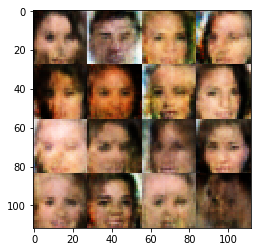

Epoch 1/2... Discriminator loss: 1.3716... Generator loss: 0.7433
Epoch 1/2... Discriminator loss: 1.3760... Generator loss: 0.8097
Epoch 1/2... Discriminator loss: 1.3598... Generator loss: 0.7954
Epoch 1/2... Discriminator loss: 1.4112... Generator loss: 0.7723
Epoch 1/2... Discriminator loss: 1.3669... Generator loss: 0.7946
Epoch 1/2... Discriminator loss: 1.4158... Generator loss: 0.7521
Epoch 1/2... Discriminator loss: 1.4155... Generator loss: 0.7875
Epoch 1/2... Discriminator loss: 1.3977... Generator loss: 0.7758
Epoch 1/2... Discriminator loss: 1.3802... Generator loss: 0.8061
Epoch 1/2... Discriminator loss: 1.4106... Generator loss: 0.7698


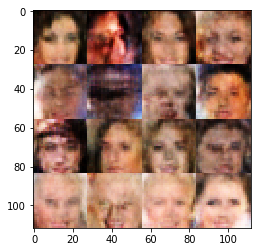

Epoch 1/2... Discriminator loss: 1.3884... Generator loss: 0.7385
Epoch 1/2... Discriminator loss: 1.4092... Generator loss: 0.7712
Epoch 1/2... Discriminator loss: 1.4083... Generator loss: 0.7570
Epoch 1/2... Discriminator loss: 1.4087... Generator loss: 0.7616
Epoch 1/2... Discriminator loss: 1.3751... Generator loss: 0.7546
Epoch 1/2... Discriminator loss: 1.3891... Generator loss: 0.7946
Epoch 1/2... Discriminator loss: 1.3685... Generator loss: 0.8061
Epoch 1/2... Discriminator loss: 1.3715... Generator loss: 0.8143
Epoch 1/2... Discriminator loss: 1.3668... Generator loss: 0.8140
Epoch 1/2... Discriminator loss: 1.3923... Generator loss: 0.8331


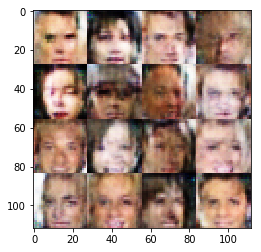

Epoch 1/2... Discriminator loss: 1.3816... Generator loss: 0.8171
Epoch 1/2... Discriminator loss: 1.3481... Generator loss: 0.8064
Epoch 1/2... Discriminator loss: 1.3672... Generator loss: 0.8429
Epoch 1/2... Discriminator loss: 1.3441... Generator loss: 0.8156
Epoch 1/2... Discriminator loss: 1.3582... Generator loss: 0.7457
Epoch 1/2... Discriminator loss: 1.3781... Generator loss: 0.7917
Epoch 1/2... Discriminator loss: 1.3676... Generator loss: 0.8273
Epoch 1/2... Discriminator loss: 1.3837... Generator loss: 0.7733
Epoch 1/2... Discriminator loss: 1.3993... Generator loss: 0.7925
Epoch 1/2... Discriminator loss: 1.4054... Generator loss: 0.8072


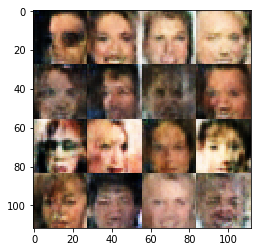

Epoch 1/2... Discriminator loss: 1.3734... Generator loss: 0.7698
Epoch 1/2... Discriminator loss: 1.4022... Generator loss: 0.7714
Epoch 1/2... Discriminator loss: 1.3925... Generator loss: 0.7875
Epoch 1/2... Discriminator loss: 1.3852... Generator loss: 0.7992
Epoch 1/2... Discriminator loss: 1.3458... Generator loss: 0.7863
Epoch 1/2... Discriminator loss: 1.4070... Generator loss: 0.7697
Epoch 1/2... Discriminator loss: 1.3813... Generator loss: 0.7920
Epoch 1/2... Discriminator loss: 1.3957... Generator loss: 0.7704
Epoch 1/2... Discriminator loss: 1.3996... Generator loss: 0.7671
Epoch 1/2... Discriminator loss: 1.3967... Generator loss: 0.7873


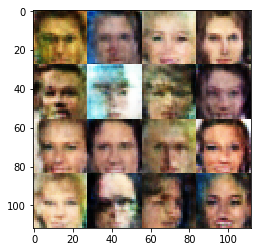

Epoch 1/2... Discriminator loss: 1.3712... Generator loss: 0.8156
Epoch 1/2... Discriminator loss: 1.3762... Generator loss: 0.8184
Epoch 1/2... Discriminator loss: 1.4156... Generator loss: 0.7856
Epoch 1/2... Discriminator loss: 1.3749... Generator loss: 0.8691
Epoch 1/2... Discriminator loss: 1.3634... Generator loss: 0.7731
Epoch 1/2... Discriminator loss: 1.4266... Generator loss: 0.7484
Epoch 1/2... Discriminator loss: 1.3915... Generator loss: 0.7651
Epoch 1/2... Discriminator loss: 1.3707... Generator loss: 0.7927
Epoch 1/2... Discriminator loss: 1.3734... Generator loss: 0.8304
Epoch 1/2... Discriminator loss: 1.3779... Generator loss: 0.7747


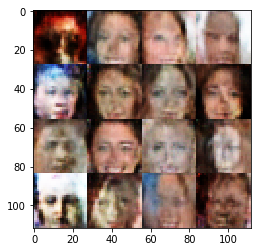

Epoch 1/2... Discriminator loss: 1.3832... Generator loss: 0.7900
Epoch 1/2... Discriminator loss: 1.3770... Generator loss: 0.8672
Epoch 1/2... Discriminator loss: 1.3732... Generator loss: 0.8061
Epoch 1/2... Discriminator loss: 1.3937... Generator loss: 0.8335
Epoch 1/2... Discriminator loss: 1.4012... Generator loss: 0.7931
Epoch 1/2... Discriminator loss: 1.3737... Generator loss: 0.8076
Epoch 1/2... Discriminator loss: 1.3840... Generator loss: 0.7655
Epoch 1/2... Discriminator loss: 1.3876... Generator loss: 0.7939
Epoch 1/2... Discriminator loss: 1.3799... Generator loss: 0.8115
Epoch 1/2... Discriminator loss: 1.3586... Generator loss: 0.8236


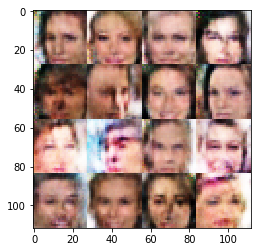

Epoch 1/2... Discriminator loss: 1.3933... Generator loss: 0.7459
Epoch 1/2... Discriminator loss: 1.3785... Generator loss: 0.8232
Epoch 1/2... Discriminator loss: 1.3858... Generator loss: 0.8007
Epoch 1/2... Discriminator loss: 1.3940... Generator loss: 0.7755
Epoch 1/2... Discriminator loss: 1.4074... Generator loss: 0.7461
Epoch 1/2... Discriminator loss: 1.3632... Generator loss: 0.8313
Epoch 1/2... Discriminator loss: 1.3970... Generator loss: 0.7472
Epoch 1/2... Discriminator loss: 1.3590... Generator loss: 0.7797
Epoch 1/2... Discriminator loss: 1.3763... Generator loss: 0.8585
Epoch 1/2... Discriminator loss: 1.3620... Generator loss: 0.7982


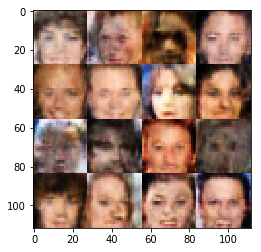

Epoch 1/2... Discriminator loss: 1.3610... Generator loss: 0.7981
Epoch 1/2... Discriminator loss: 1.3629... Generator loss: 0.7740
Epoch 1/2... Discriminator loss: 1.4075... Generator loss: 0.8199
Epoch 1/2... Discriminator loss: 1.4110... Generator loss: 0.7940
Epoch 1/2... Discriminator loss: 1.3252... Generator loss: 0.8681
Epoch 1/2... Discriminator loss: 1.3926... Generator loss: 0.7660
Epoch 1/2... Discriminator loss: 1.3779... Generator loss: 0.8131
Epoch 1/2... Discriminator loss: 1.3924... Generator loss: 0.7778
Epoch 1/2... Discriminator loss: 1.4012... Generator loss: 0.8384
Epoch 1/2... Discriminator loss: 1.3852... Generator loss: 0.7510


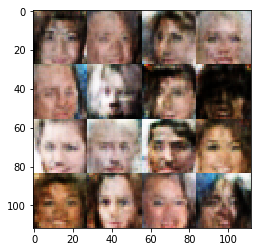

Epoch 1/2... Discriminator loss: 1.3837... Generator loss: 0.8097
Epoch 1/2... Discriminator loss: 1.4143... Generator loss: 0.7783
Epoch 1/2... Discriminator loss: 1.3548... Generator loss: 0.8058
Epoch 1/2... Discriminator loss: 1.3863... Generator loss: 0.8152
Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.8122
Epoch 1/2... Discriminator loss: 1.3865... Generator loss: 0.7773
Epoch 1/2... Discriminator loss: 1.3658... Generator loss: 0.8185
Epoch 1/2... Discriminator loss: 1.3714... Generator loss: 0.7791
Epoch 1/2... Discriminator loss: 1.3757... Generator loss: 0.8147
Epoch 1/2... Discriminator loss: 1.3866... Generator loss: 0.8293


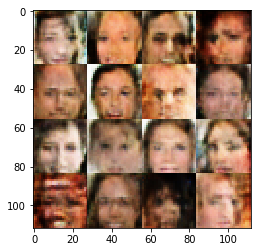

Epoch 1/2... Discriminator loss: 1.3788... Generator loss: 0.7893
Epoch 1/2... Discriminator loss: 1.3856... Generator loss: 0.8147
Epoch 1/2... Discriminator loss: 1.3502... Generator loss: 0.7974
Epoch 1/2... Discriminator loss: 1.3864... Generator loss: 0.7921
Epoch 1/2... Discriminator loss: 1.3965... Generator loss: 0.7911
Epoch 1/2... Discriminator loss: 1.3271... Generator loss: 0.8401
Epoch 1/2... Discriminator loss: 1.3641... Generator loss: 0.8078
Epoch 1/2... Discriminator loss: 1.3746... Generator loss: 0.8225
Epoch 1/2... Discriminator loss: 1.3685... Generator loss: 0.7939
Epoch 1/2... Discriminator loss: 1.3679... Generator loss: 0.8007


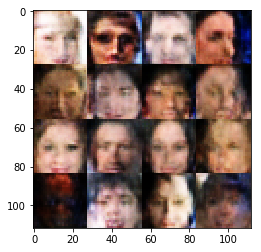

Epoch 1/2... Discriminator loss: 1.3931... Generator loss: 0.8082
Epoch 1/2... Discriminator loss: 1.3930... Generator loss: 0.7438
Epoch 1/2... Discriminator loss: 1.3743... Generator loss: 0.8016
Epoch 1/2... Discriminator loss: 1.3735... Generator loss: 0.7982
Epoch 1/2... Discriminator loss: 1.3384... Generator loss: 0.8349
Epoch 1/2... Discriminator loss: 1.4362... Generator loss: 0.7497
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 0.7826
Epoch 1/2... Discriminator loss: 1.3944... Generator loss: 0.7906
Epoch 1/2... Discriminator loss: 1.3953... Generator loss: 0.8179
Epoch 1/2... Discriminator loss: 1.3961... Generator loss: 0.7916


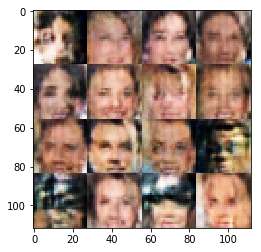

Epoch 1/2... Discriminator loss: 1.3803... Generator loss: 0.8108
Epoch 1/2... Discriminator loss: 1.3761... Generator loss: 0.8128
Epoch 1/2... Discriminator loss: 1.3529... Generator loss: 0.7869
Epoch 1/2... Discriminator loss: 1.3594... Generator loss: 0.7811
Epoch 1/2... Discriminator loss: 1.3885... Generator loss: 0.7829
Epoch 1/2... Discriminator loss: 1.3785... Generator loss: 0.7682
Epoch 1/2... Discriminator loss: 1.3883... Generator loss: 0.8176
Epoch 1/2... Discriminator loss: 1.3737... Generator loss: 0.8109
Epoch 1/2... Discriminator loss: 1.3479... Generator loss: 0.7905
Epoch 1/2... Discriminator loss: 1.3923... Generator loss: 0.7848


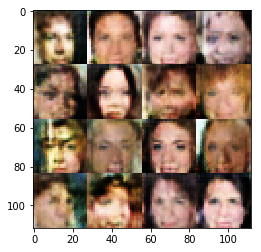

Epoch 1/2... Discriminator loss: 1.4017... Generator loss: 0.7709
Epoch 1/2... Discriminator loss: 1.3489... Generator loss: 0.8072
Epoch 1/2... Discriminator loss: 1.3637... Generator loss: 0.8180
Epoch 1/2... Discriminator loss: 1.3771... Generator loss: 0.8115
Epoch 1/2... Discriminator loss: 1.3845... Generator loss: 0.7845
Epoch 1/2... Discriminator loss: 1.3764... Generator loss: 0.7948
Epoch 1/2... Discriminator loss: 1.4058... Generator loss: 0.7876
Epoch 1/2... Discriminator loss: 1.3756... Generator loss: 0.8138
Epoch 1/2... Discriminator loss: 1.3513... Generator loss: 0.8241
Epoch 1/2... Discriminator loss: 1.3946... Generator loss: 0.7773


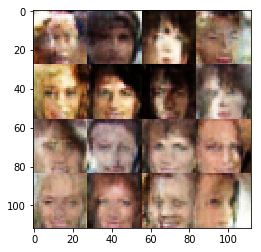

Epoch 1/2... Discriminator loss: 1.4029... Generator loss: 0.7978
Epoch 1/2... Discriminator loss: 1.4239... Generator loss: 0.7937
Epoch 1/2... Discriminator loss: 1.3819... Generator loss: 0.8095
Epoch 1/2... Discriminator loss: 1.4247... Generator loss: 0.7324
Epoch 1/2... Discriminator loss: 1.3819... Generator loss: 0.8418
Epoch 1/2... Discriminator loss: 1.4085... Generator loss: 0.7563
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 0.7632
Epoch 1/2... Discriminator loss: 1.3611... Generator loss: 0.7729
Epoch 1/2... Discriminator loss: 1.3683... Generator loss: 0.8140
Epoch 1/2... Discriminator loss: 1.3953... Generator loss: 0.8166


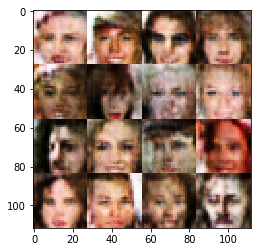

Epoch 1/2... Discriminator loss: 1.4021... Generator loss: 0.7505
Epoch 1/2... Discriminator loss: 1.3773... Generator loss: 0.8181
Epoch 1/2... Discriminator loss: 1.3679... Generator loss: 0.7676
Epoch 1/2... Discriminator loss: 1.4064... Generator loss: 0.7419
Epoch 1/2... Discriminator loss: 1.3703... Generator loss: 0.8106
Epoch 1/2... Discriminator loss: 1.3957... Generator loss: 0.8141
Epoch 1/2... Discriminator loss: 1.3772... Generator loss: 0.7963
Epoch 1/2... Discriminator loss: 1.3792... Generator loss: 0.7528
Epoch 1/2... Discriminator loss: 1.3877... Generator loss: 0.7844
Epoch 1/2... Discriminator loss: 1.3944... Generator loss: 0.7967


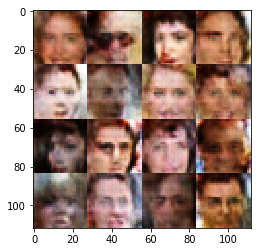

Epoch 1/2... Discriminator loss: 1.3582... Generator loss: 0.8232
Epoch 1/2... Discriminator loss: 1.3688... Generator loss: 0.7470
Epoch 1/2... Discriminator loss: 1.3916... Generator loss: 0.8211
Epoch 1/2... Discriminator loss: 1.3651... Generator loss: 0.8096
Epoch 1/2... Discriminator loss: 1.3884... Generator loss: 0.7777
Epoch 1/2... Discriminator loss: 1.3667... Generator loss: 0.7888
Epoch 1/2... Discriminator loss: 1.4050... Generator loss: 0.7832
Epoch 1/2... Discriminator loss: 1.3975... Generator loss: 0.7961
Epoch 1/2... Discriminator loss: 1.3841... Generator loss: 0.8234
Epoch 1/2... Discriminator loss: 1.3911... Generator loss: 0.7865


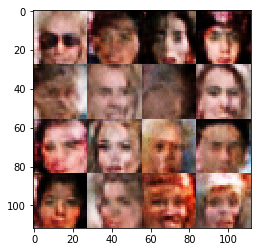

Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.8478
Epoch 1/2... Discriminator loss: 1.3791... Generator loss: 0.7762
Epoch 1/2... Discriminator loss: 1.3719... Generator loss: 0.7712
Epoch 1/2... Discriminator loss: 1.3812... Generator loss: 0.7783
Epoch 1/2... Discriminator loss: 1.3987... Generator loss: 0.8227
Epoch 1/2... Discriminator loss: 1.3932... Generator loss: 0.7975
Epoch 1/2... Discriminator loss: 1.3582... Generator loss: 0.8049
Epoch 1/2... Discriminator loss: 1.3886... Generator loss: 0.8070
Epoch 1/2... Discriminator loss: 1.3620... Generator loss: 0.8222
Epoch 1/2... Discriminator loss: 1.3827... Generator loss: 0.8037


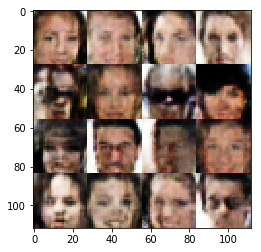

Epoch 1/2... Discriminator loss: 1.3784... Generator loss: 0.7123
Epoch 1/2... Discriminator loss: 1.3269... Generator loss: 0.8179
Epoch 1/2... Discriminator loss: 1.3525... Generator loss: 0.8787
Epoch 1/2... Discriminator loss: 1.3657... Generator loss: 0.8108
Epoch 1/2... Discriminator loss: 1.3815... Generator loss: 0.8155
Epoch 1/2... Discriminator loss: 1.3961... Generator loss: 0.8015
Epoch 1/2... Discriminator loss: 1.4006... Generator loss: 0.7876
Epoch 1/2... Discriminator loss: 1.3913... Generator loss: 0.7952
Epoch 1/2... Discriminator loss: 1.3996... Generator loss: 0.8017
Epoch 1/2... Discriminator loss: 1.3951... Generator loss: 0.8009


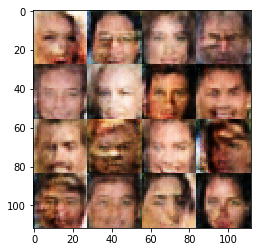

Epoch 1/2... Discriminator loss: 1.3823... Generator loss: 0.7660
Epoch 1/2... Discriminator loss: 1.3655... Generator loss: 0.7800
Epoch 1/2... Discriminator loss: 1.3536... Generator loss: 0.8109
Epoch 1/2... Discriminator loss: 1.3853... Generator loss: 0.7892
Epoch 1/2... Discriminator loss: 1.3536... Generator loss: 0.7781
Epoch 1/2... Discriminator loss: 1.3955... Generator loss: 0.8047
Epoch 1/2... Discriminator loss: 1.3507... Generator loss: 0.8208
Epoch 1/2... Discriminator loss: 1.3806... Generator loss: 0.7743
Epoch 1/2... Discriminator loss: 1.3904... Generator loss: 0.8251
Epoch 1/2... Discriminator loss: 1.3704... Generator loss: 0.7958


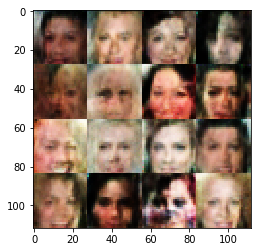

Epoch 1/2... Discriminator loss: 1.4427... Generator loss: 0.7778
Epoch 1/2... Discriminator loss: 1.3831... Generator loss: 0.7560
Epoch 1/2... Discriminator loss: 1.3971... Generator loss: 0.7681
Epoch 1/2... Discriminator loss: 1.3725... Generator loss: 0.8232
Epoch 1/2... Discriminator loss: 1.4114... Generator loss: 0.8105
Epoch 1/2... Discriminator loss: 1.3883... Generator loss: 0.7779
Epoch 1/2... Discriminator loss: 1.3764... Generator loss: 0.8278
Epoch 1/2... Discriminator loss: 1.3718... Generator loss: 0.7742
Epoch 1/2... Discriminator loss: 1.3348... Generator loss: 0.8640
Epoch 1/2... Discriminator loss: 1.3753... Generator loss: 0.7828


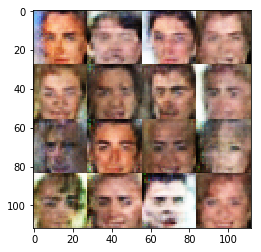

Epoch 1/2... Discriminator loss: 1.3519... Generator loss: 0.8418
Epoch 1/2... Discriminator loss: 1.4174... Generator loss: 0.7787
Epoch 1/2... Discriminator loss: 1.3884... Generator loss: 0.7613
Epoch 1/2... Discriminator loss: 1.3767... Generator loss: 0.7887
Epoch 1/2... Discriminator loss: 1.3658... Generator loss: 0.7992
Epoch 1/2... Discriminator loss: 1.3903... Generator loss: 0.7847
Epoch 1/2... Discriminator loss: 1.4110... Generator loss: 0.7639
Epoch 1/2... Discriminator loss: 1.3812... Generator loss: 0.7696
Epoch 1/2... Discriminator loss: 1.4027... Generator loss: 0.7501
Epoch 1/2... Discriminator loss: 1.3833... Generator loss: 0.7556


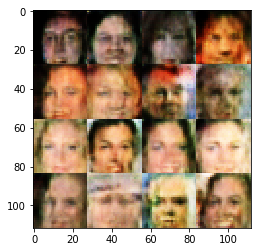

Epoch 1/2... Discriminator loss: 1.3946... Generator loss: 0.7918
Epoch 1/2... Discriminator loss: 1.3682... Generator loss: 0.7600
Epoch 1/2... Discriminator loss: 1.3850... Generator loss: 0.7924
Epoch 1/2... Discriminator loss: 1.3814... Generator loss: 0.7790
Epoch 1/2... Discriminator loss: 1.3945... Generator loss: 0.7931
Epoch 1/2... Discriminator loss: 1.3656... Generator loss: 0.8535
Epoch 1/2... Discriminator loss: 1.4047... Generator loss: 0.7792
Epoch 1/2... Discriminator loss: 1.3684... Generator loss: 0.7977
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 0.8108
Epoch 1/2... Discriminator loss: 1.3698... Generator loss: 0.7944


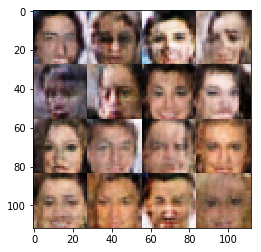

Epoch 1/2... Discriminator loss: 1.3784... Generator loss: 0.8277
Epoch 1/2... Discriminator loss: 1.3941... Generator loss: 0.8004
Epoch 1/2... Discriminator loss: 1.3995... Generator loss: 0.7885
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 0.8360
Epoch 1/2... Discriminator loss: 1.3695... Generator loss: 0.8178
Epoch 1/2... Discriminator loss: 1.3691... Generator loss: 0.8405
Epoch 1/2... Discriminator loss: 1.3803... Generator loss: 0.7710
Epoch 1/2... Discriminator loss: 1.3719... Generator loss: 0.8347
Epoch 1/2... Discriminator loss: 1.4022... Generator loss: 0.7554
Epoch 1/2... Discriminator loss: 1.3786... Generator loss: 0.7589


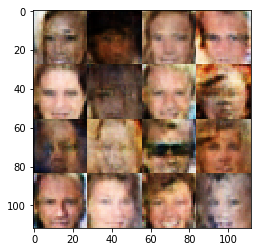

Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.7993
Epoch 1/2... Discriminator loss: 1.3913... Generator loss: 0.7786
Epoch 1/2... Discriminator loss: 1.3830... Generator loss: 0.7641
Epoch 1/2... Discriminator loss: 1.3923... Generator loss: 0.7978
Epoch 1/2... Discriminator loss: 1.3869... Generator loss: 0.8376
Epoch 1/2... Discriminator loss: 1.3939... Generator loss: 0.7639
Epoch 1/2... Discriminator loss: 1.3994... Generator loss: 0.7913
Epoch 1/2... Discriminator loss: 1.4093... Generator loss: 0.7998
Epoch 1/2... Discriminator loss: 1.3958... Generator loss: 0.7817
Epoch 1/2... Discriminator loss: 1.4025... Generator loss: 0.7619


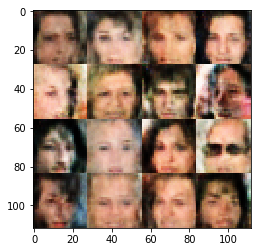

Epoch 1/2... Discriminator loss: 1.4017... Generator loss: 0.7615
Epoch 1/2... Discriminator loss: 1.3971... Generator loss: 0.8032
Epoch 1/2... Discriminator loss: 1.3900... Generator loss: 0.7746
Epoch 1/2... Discriminator loss: 1.3710... Generator loss: 0.7995
Epoch 1/2... Discriminator loss: 1.3740... Generator loss: 0.7992
Epoch 1/2... Discriminator loss: 1.3615... Generator loss: 0.7644
Epoch 1/2... Discriminator loss: 1.3896... Generator loss: 0.8188
Epoch 1/2... Discriminator loss: 1.3866... Generator loss: 0.7832
Epoch 1/2... Discriminator loss: 1.3958... Generator loss: 0.7870
Epoch 1/2... Discriminator loss: 1.3744... Generator loss: 0.7831


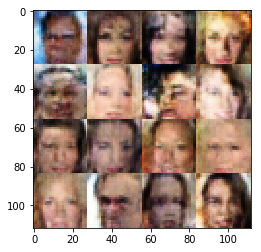

Epoch 1/2... Discriminator loss: 1.3540... Generator loss: 0.8040
Epoch 1/2... Discriminator loss: 1.3843... Generator loss: 0.7874
Epoch 1/2... Discriminator loss: 1.3511... Generator loss: 0.8276
Epoch 1/2... Discriminator loss: 1.3912... Generator loss: 0.7803
Epoch 1/2... Discriminator loss: 1.3852... Generator loss: 0.7743
Epoch 1/2... Discriminator loss: 1.3655... Generator loss: 0.8044
Epoch 1/2... Discriminator loss: 1.4023... Generator loss: 0.7822
Epoch 1/2... Discriminator loss: 1.3835... Generator loss: 0.7887
Epoch 1/2... Discriminator loss: 1.4007... Generator loss: 0.7953
Epoch 1/2... Discriminator loss: 1.3906... Generator loss: 0.7407


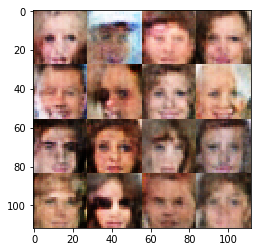

Epoch 1/2... Discriminator loss: 1.4024... Generator loss: 0.7696
Epoch 1/2... Discriminator loss: 1.4012... Generator loss: 0.8087
Epoch 1/2... Discriminator loss: 1.3883... Generator loss: 0.7504
Epoch 1/2... Discriminator loss: 1.4125... Generator loss: 0.7764
Epoch 1/2... Discriminator loss: 1.3748... Generator loss: 0.7914
Epoch 1/2... Discriminator loss: 1.3865... Generator loss: 0.8028
Epoch 1/2... Discriminator loss: 1.3903... Generator loss: 0.8004
Epoch 1/2... Discriminator loss: 1.4053... Generator loss: 0.7997
Epoch 1/2... Discriminator loss: 1.3700... Generator loss: 0.7984
Epoch 1/2... Discriminator loss: 1.4195... Generator loss: 0.7716


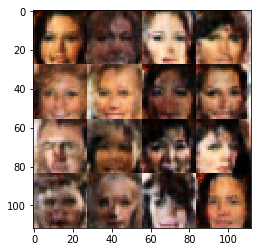

Epoch 1/2... Discriminator loss: 1.3566... Generator loss: 0.7956
Epoch 1/2... Discriminator loss: 1.3842... Generator loss: 0.7928
Epoch 1/2... Discriminator loss: 1.3769... Generator loss: 0.7885
Epoch 1/2... Discriminator loss: 1.4113... Generator loss: 0.7817
Epoch 1/2... Discriminator loss: 1.4180... Generator loss: 0.7632
Epoch 1/2... Discriminator loss: 1.3887... Generator loss: 0.8210
Epoch 1/2... Discriminator loss: 1.3830... Generator loss: 0.7832
Epoch 1/2... Discriminator loss: 1.3994... Generator loss: 0.7710
Epoch 1/2... Discriminator loss: 1.3961... Generator loss: 0.7936
Epoch 1/2... Discriminator loss: 1.3923... Generator loss: 0.8235


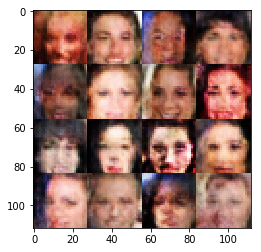

Epoch 1/2... Discriminator loss: 1.3743... Generator loss: 0.8148
Epoch 1/2... Discriminator loss: 1.3812... Generator loss: 0.8060
Epoch 1/2... Discriminator loss: 1.3596... Generator loss: 0.8458
Epoch 1/2... Discriminator loss: 1.4132... Generator loss: 0.7430
Epoch 1/2... Discriminator loss: 1.3626... Generator loss: 0.8196
Epoch 1/2... Discriminator loss: 1.3867... Generator loss: 0.7755
Epoch 1/2... Discriminator loss: 1.3776... Generator loss: 0.8058
Epoch 1/2... Discriminator loss: 1.3949... Generator loss: 0.7859
Epoch 1/2... Discriminator loss: 1.3516... Generator loss: 0.8133
Epoch 1/2... Discriminator loss: 1.3843... Generator loss: 0.7902


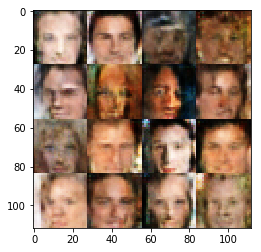

Epoch 1/2... Discriminator loss: 1.3903... Generator loss: 0.7594
Epoch 1/2... Discriminator loss: 1.3992... Generator loss: 0.7510
Epoch 1/2... Discriminator loss: 1.3886... Generator loss: 0.7835
Epoch 1/2... Discriminator loss: 1.3675... Generator loss: 0.8191
Epoch 1/2... Discriminator loss: 1.3771... Generator loss: 0.7759
Epoch 1/2... Discriminator loss: 1.3408... Generator loss: 0.8011
Epoch 1/2... Discriminator loss: 1.3707... Generator loss: 0.8054
Epoch 1/2... Discriminator loss: 1.3855... Generator loss: 0.7662
Epoch 1/2... Discriminator loss: 1.3945... Generator loss: 0.7719
Epoch 1/2... Discriminator loss: 1.3714... Generator loss: 0.7897


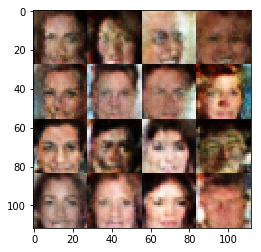

Epoch 1/2... Discriminator loss: 1.3811... Generator loss: 0.7693
Epoch 1/2... Discriminator loss: 1.4097... Generator loss: 0.7500
Epoch 1/2... Discriminator loss: 1.3880... Generator loss: 0.7643
Epoch 1/2... Discriminator loss: 1.4287... Generator loss: 0.7579
Epoch 1/2... Discriminator loss: 1.3619... Generator loss: 0.7856
Epoch 1/2... Discriminator loss: 1.3678... Generator loss: 0.7830
Epoch 1/2... Discriminator loss: 1.3970... Generator loss: 0.8445
Epoch 1/2... Discriminator loss: 1.3674... Generator loss: 0.7647
Epoch 1/2... Discriminator loss: 1.4003... Generator loss: 0.7905
Epoch 1/2... Discriminator loss: 1.3603... Generator loss: 0.7839


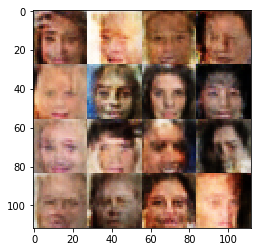

Epoch 1/2... Discriminator loss: 1.4115... Generator loss: 0.7933
Epoch 1/2... Discriminator loss: 1.3789... Generator loss: 0.7550
Epoch 1/2... Discriminator loss: 1.3859... Generator loss: 0.7875
Epoch 1/2... Discriminator loss: 1.3844... Generator loss: 0.7837
Epoch 1/2... Discriminator loss: 1.3802... Generator loss: 0.7927
Epoch 1/2... Discriminator loss: 1.3676... Generator loss: 0.8114
Epoch 1/2... Discriminator loss: 1.3915... Generator loss: 0.7990
Epoch 1/2... Discriminator loss: 1.3762... Generator loss: 0.8232
Epoch 1/2... Discriminator loss: 1.3815... Generator loss: 0.7942
Epoch 1/2... Discriminator loss: 1.3942... Generator loss: 0.7857


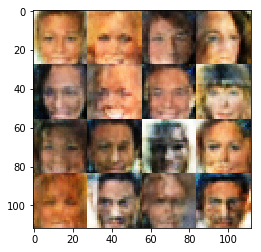

Epoch 1/2... Discriminator loss: 1.3777... Generator loss: 0.7777
Epoch 1/2... Discriminator loss: 1.3602... Generator loss: 0.7957
Epoch 1/2... Discriminator loss: 1.3847... Generator loss: 0.7836
Epoch 1/2... Discriminator loss: 1.3452... Generator loss: 0.8514
Epoch 1/2... Discriminator loss: 1.4151... Generator loss: 0.7623
Epoch 1/2... Discriminator loss: 1.3931... Generator loss: 0.7611
Epoch 1/2... Discriminator loss: 1.3657... Generator loss: 0.8365
Epoch 1/2... Discriminator loss: 1.3952... Generator loss: 0.7708
Epoch 1/2... Discriminator loss: 1.4011... Generator loss: 0.7723
Epoch 1/2... Discriminator loss: 1.3929... Generator loss: 0.7389


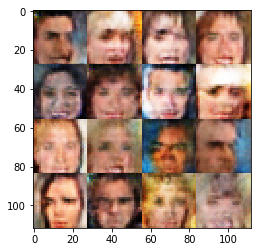

Epoch 1/2... Discriminator loss: 1.3845... Generator loss: 0.8127
Epoch 1/2... Discriminator loss: 1.4030... Generator loss: 0.7623
Epoch 1/2... Discriminator loss: 1.3631... Generator loss: 0.7781
Epoch 1/2... Discriminator loss: 1.3883... Generator loss: 0.7843
Epoch 1/2... Discriminator loss: 1.3883... Generator loss: 0.7864
Epoch 1/2... Discriminator loss: 1.3896... Generator loss: 0.8179
Epoch 1/2... Discriminator loss: 1.3887... Generator loss: 0.7967
Epoch 1/2... Discriminator loss: 1.3539... Generator loss: 0.8188
Epoch 1/2... Discriminator loss: 1.3503... Generator loss: 0.8260
Epoch 1/2... Discriminator loss: 1.3737... Generator loss: 0.7657


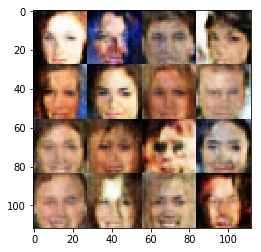

Epoch 1/2... Discriminator loss: 1.3558... Generator loss: 0.7860
Epoch 1/2... Discriminator loss: 1.3813... Generator loss: 0.7974
Epoch 1/2... Discriminator loss: 1.3549... Generator loss: 0.8065
Epoch 1/2... Discriminator loss: 1.3669... Generator loss: 0.8135
Epoch 1/2... Discriminator loss: 1.4174... Generator loss: 0.7550
Epoch 1/2... Discriminator loss: 1.4085... Generator loss: 0.7568
Epoch 1/2... Discriminator loss: 1.3520... Generator loss: 0.7638
Epoch 1/2... Discriminator loss: 1.3784... Generator loss: 0.7528
Epoch 1/2... Discriminator loss: 1.3532... Generator loss: 0.8148
Epoch 1/2... Discriminator loss: 1.3952... Generator loss: 0.7781


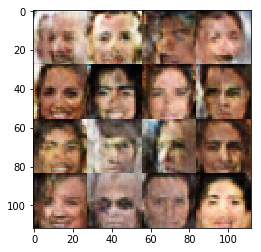

Epoch 1/2... Discriminator loss: 1.4095... Generator loss: 0.7547
Epoch 1/2... Discriminator loss: 1.3786... Generator loss: 0.7910
Epoch 1/2... Discriminator loss: 1.4003... Generator loss: 0.8052
Epoch 1/2... Discriminator loss: 1.3466... Generator loss: 0.7709
Epoch 1/2... Discriminator loss: 1.4135... Generator loss: 0.7918
Epoch 1/2... Discriminator loss: 1.3632... Generator loss: 0.8004
Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.7983
Epoch 1/2... Discriminator loss: 1.4022... Generator loss: 0.7644
Epoch 1/2... Discriminator loss: 1.3881... Generator loss: 0.8169
Epoch 1/2... Discriminator loss: 1.3753... Generator loss: 0.8010


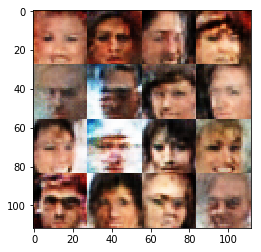

Epoch 1/2... Discriminator loss: 1.3563... Generator loss: 0.7857
Epoch 1/2... Discriminator loss: 1.3530... Generator loss: 0.7933
Epoch 1/2... Discriminator loss: 1.3892... Generator loss: 0.8299
Epoch 1/2... Discriminator loss: 1.4202... Generator loss: 0.7852
Epoch 1/2... Discriminator loss: 1.3666... Generator loss: 0.7585
Epoch 1/2... Discriminator loss: 1.3824... Generator loss: 0.8119
Epoch 1/2... Discriminator loss: 1.3895... Generator loss: 0.8039
Epoch 1/2... Discriminator loss: 1.3350... Generator loss: 0.8159
Epoch 1/2... Discriminator loss: 1.3788... Generator loss: 0.7793
Epoch 1/2... Discriminator loss: 1.3721... Generator loss: 0.8051


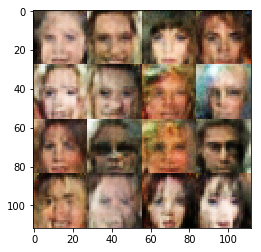

Epoch 1/2... Discriminator loss: 1.3736... Generator loss: 0.8147
Epoch 1/2... Discriminator loss: 1.3676... Generator loss: 0.7943
Epoch 1/2... Discriminator loss: 1.3870... Generator loss: 0.7720
Epoch 1/2... Discriminator loss: 1.4028... Generator loss: 0.8153
Epoch 1/2... Discriminator loss: 1.3734... Generator loss: 0.7970
Epoch 1/2... Discriminator loss: 1.3779... Generator loss: 0.8121
Epoch 1/2... Discriminator loss: 1.3635... Generator loss: 0.7845
Epoch 1/2... Discriminator loss: 1.3805... Generator loss: 0.8044
Epoch 1/2... Discriminator loss: 1.4014... Generator loss: 0.7887
Epoch 1/2... Discriminator loss: 1.3659... Generator loss: 0.7699


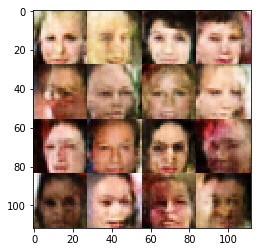

Epoch 1/2... Discriminator loss: 1.4082... Generator loss: 0.7901
Epoch 1/2... Discriminator loss: 1.3991... Generator loss: 0.8058
Epoch 1/2... Discriminator loss: 1.3491... Generator loss: 0.8402
Epoch 1/2... Discriminator loss: 1.3982... Generator loss: 0.8142
Epoch 1/2... Discriminator loss: 1.3769... Generator loss: 0.8163
Epoch 1/2... Discriminator loss: 1.3863... Generator loss: 0.7882
Epoch 1/2... Discriminator loss: 1.3722... Generator loss: 0.8128
Epoch 1/2... Discriminator loss: 1.3829... Generator loss: 0.8104
Epoch 1/2... Discriminator loss: 1.3657... Generator loss: 0.7756
Epoch 1/2... Discriminator loss: 1.3777... Generator loss: 0.7877


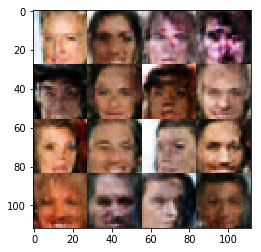

Epoch 1/2... Discriminator loss: 1.3608... Generator loss: 0.8096
Epoch 1/2... Discriminator loss: 1.4182... Generator loss: 0.7572
Epoch 1/2... Discriminator loss: 1.3775... Generator loss: 0.7903
Epoch 1/2... Discriminator loss: 1.4044... Generator loss: 0.7477
Epoch 1/2... Discriminator loss: 1.3866... Generator loss: 0.7896
Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.7941
Epoch 1/2... Discriminator loss: 1.3909... Generator loss: 0.8261
Epoch 1/2... Discriminator loss: 1.3627... Generator loss: 0.8091
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 0.7711
Epoch 1/2... Discriminator loss: 1.3888... Generator loss: 0.7954


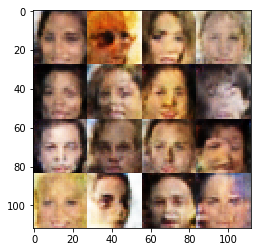

Epoch 1/2... Discriminator loss: 1.3646... Generator loss: 0.7963
Epoch 1/2... Discriminator loss: 1.3776... Generator loss: 0.8125
Epoch 1/2... Discriminator loss: 1.3606... Generator loss: 0.8241
Epoch 1/2... Discriminator loss: 1.3833... Generator loss: 0.8016
Epoch 1/2... Discriminator loss: 1.3900... Generator loss: 0.8052
Epoch 1/2... Discriminator loss: 1.3867... Generator loss: 0.7447
Epoch 1/2... Discriminator loss: 1.3648... Generator loss: 0.8082
Epoch 1/2... Discriminator loss: 1.3877... Generator loss: 0.8177
Epoch 1/2... Discriminator loss: 1.3866... Generator loss: 0.8194
Epoch 1/2... Discriminator loss: 1.4075... Generator loss: 0.7835


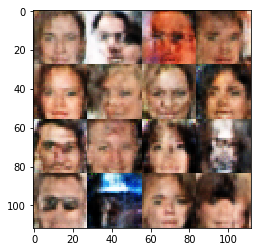

Epoch 1/2... Discriminator loss: 1.4011... Generator loss: 0.8028
Epoch 1/2... Discriminator loss: 1.3639... Generator loss: 0.7852
Epoch 1/2... Discriminator loss: 1.3980... Generator loss: 0.7964
Epoch 1/2... Discriminator loss: 1.3619... Generator loss: 0.8430
Epoch 1/2... Discriminator loss: 1.3918... Generator loss: 0.7997
Epoch 1/2... Discriminator loss: 1.3883... Generator loss: 0.7808
Epoch 1/2... Discriminator loss: 1.3865... Generator loss: 0.7785
Epoch 1/2... Discriminator loss: 1.3991... Generator loss: 0.8026
Epoch 1/2... Discriminator loss: 1.3833... Generator loss: 0.8106
Epoch 1/2... Discriminator loss: 1.3943... Generator loss: 0.8076


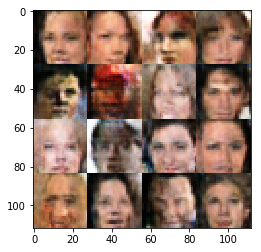

Epoch 1/2... Discriminator loss: 1.3582... Generator loss: 0.7869
Epoch 1/2... Discriminator loss: 1.3973... Generator loss: 0.7593
Epoch 1/2... Discriminator loss: 1.3561... Generator loss: 0.7800
Epoch 1/2... Discriminator loss: 1.3917... Generator loss: 0.7926
Epoch 1/2... Discriminator loss: 1.3641... Generator loss: 0.7810
Epoch 1/2... Discriminator loss: 1.4127... Generator loss: 0.7683
Epoch 1/2... Discriminator loss: 1.3636... Generator loss: 0.7638
Epoch 1/2... Discriminator loss: 1.3625... Generator loss: 0.8162
Epoch 1/2... Discriminator loss: 1.3591... Generator loss: 0.8253
Epoch 1/2... Discriminator loss: 1.3752... Generator loss: 0.7793


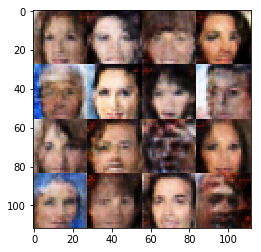

Epoch 1/2... Discriminator loss: 1.3999... Generator loss: 0.7884
Epoch 1/2... Discriminator loss: 1.3722... Generator loss: 0.7759
Epoch 1/2... Discriminator loss: 1.3794... Generator loss: 0.7953
Epoch 1/2... Discriminator loss: 1.3580... Generator loss: 0.8000
Epoch 1/2... Discriminator loss: 1.3543... Generator loss: 0.8138
Epoch 1/2... Discriminator loss: 1.3845... Generator loss: 0.7752
Epoch 1/2... Discriminator loss: 1.3821... Generator loss: 0.7790
Epoch 1/2... Discriminator loss: 1.3669... Generator loss: 0.7729
Epoch 1/2... Discriminator loss: 1.3680... Generator loss: 0.7910
Epoch 1/2... Discriminator loss: 1.3761... Generator loss: 0.7781


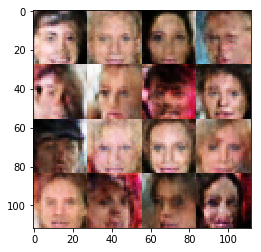

Epoch 1/2... Discriminator loss: 1.3902... Generator loss: 0.7865
Epoch 1/2... Discriminator loss: 1.3777... Generator loss: 0.8056
Epoch 1/2... Discriminator loss: 1.4042... Generator loss: 0.7749
Epoch 1/2... Discriminator loss: 1.3612... Generator loss: 0.8194
Epoch 1/2... Discriminator loss: 1.4107... Generator loss: 0.7481
Epoch 1/2... Discriminator loss: 1.3802... Generator loss: 0.8000
Epoch 1/2... Discriminator loss: 1.3823... Generator loss: 0.7883
Epoch 1/2... Discriminator loss: 1.3886... Generator loss: 0.7765
Epoch 1/2... Discriminator loss: 1.3724... Generator loss: 0.8125
Epoch 1/2... Discriminator loss: 1.3733... Generator loss: 0.8485


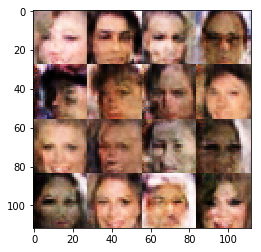

Epoch 1/2... Discriminator loss: 1.3949... Generator loss: 0.8269
Epoch 1/2... Discriminator loss: 1.4037... Generator loss: 0.7688
Epoch 1/2... Discriminator loss: 1.3847... Generator loss: 0.7818
Epoch 1/2... Discriminator loss: 1.3947... Generator loss: 0.7788
Epoch 1/2... Discriminator loss: 1.3705... Generator loss: 0.8090
Epoch 1/2... Discriminator loss: 1.3796... Generator loss: 0.8022
Epoch 1/2... Discriminator loss: 1.3489... Generator loss: 0.8131
Epoch 1/2... Discriminator loss: 1.3615... Generator loss: 0.7911
Epoch 1/2... Discriminator loss: 1.3704... Generator loss: 0.8013
Epoch 1/2... Discriminator loss: 1.4158... Generator loss: 0.7254


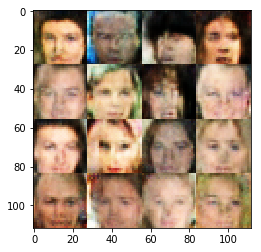

Epoch 1/2... Discriminator loss: 1.3951... Generator loss: 0.7882
Epoch 1/2... Discriminator loss: 1.3761... Generator loss: 0.8113
Epoch 1/2... Discriminator loss: 1.3710... Generator loss: 0.8097
Epoch 1/2... Discriminator loss: 1.3894... Generator loss: 0.8083
Epoch 1/2... Discriminator loss: 1.3820... Generator loss: 0.7863
Epoch 1/2... Discriminator loss: 1.3787... Generator loss: 0.8167
Epoch 1/2... Discriminator loss: 1.3486... Generator loss: 0.7995
Epoch 1/2... Discriminator loss: 1.4072... Generator loss: 0.7671
Epoch 1/2... Discriminator loss: 1.3930... Generator loss: 0.7229
Epoch 1/2... Discriminator loss: 1.3698... Generator loss: 0.7968


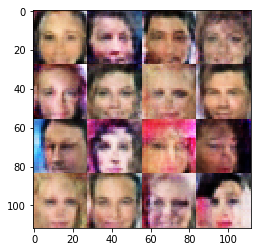

Epoch 1/2... Discriminator loss: 1.3683... Generator loss: 0.8060
Epoch 1/2... Discriminator loss: 1.3661... Generator loss: 0.8279
Epoch 1/2... Discriminator loss: 1.3812... Generator loss: 0.7787
Epoch 1/2... Discriminator loss: 1.3535... Generator loss: 0.7931
Epoch 1/2... Discriminator loss: 1.3656... Generator loss: 0.7771
Epoch 1/2... Discriminator loss: 1.3856... Generator loss: 0.7965
Epoch 1/2... Discriminator loss: 1.3779... Generator loss: 0.8056
Epoch 1/2... Discriminator loss: 1.3988... Generator loss: 0.8089
Epoch 1/2... Discriminator loss: 1.3768... Generator loss: 0.8174
Epoch 1/2... Discriminator loss: 1.3841... Generator loss: 0.7717


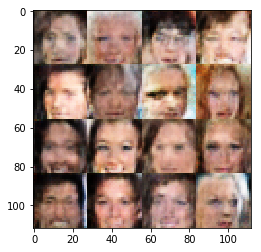

Epoch 1/2... Discriminator loss: 1.3867... Generator loss: 0.7804
Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.7882
Epoch 1/2... Discriminator loss: 1.3865... Generator loss: 0.7672
Epoch 1/2... Discriminator loss: 1.3885... Generator loss: 0.7856
Epoch 1/2... Discriminator loss: 1.3904... Generator loss: 0.7860
Epoch 1/2... Discriminator loss: 1.3828... Generator loss: 0.8014


In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.